<center><h1>Final Project</h1></center>
<center><h2><i>Stephane Gurgenidze & Davit Chechelashvili</i></h2></center>

<h1><span style="color:blue">Table of Contents</span></h1>

<li><a href="#About-Problem">About Problem</a></li>
<li><a href="#Task-Details">Task Details</a></li>
<li><a href="#Used-Libraries">Used Libraries</a></li>
<li><a href="#Dataset-Preview">Dataset Preview</a></li>
<li><a href="#Dataset-Columns">Dataset Columns</a></li>
<li><a href="#Get-to-Know-Your-Data">Get to Know Your Data</a></li>
<li><a href="#Creating-Food-Dataframe">Creating Food Dataframe</a></li>
<li><a href="#Removing-Outliers-With-IQR">Removing Outliers With IQR</a></li>
<li><a href="#Removing-Outliers-With-Projection-Method">Removing Outliers With Projection Method</a></li>
<li><a href="#Collating-Food-Entries">Collating Food Entries</a></li>
<li><a href="#EDA-(Exploratory-Data-Analysis)">EDA (Exploratory Data Analysis)</a></li>
<li><a href="#Feature-Engineering">Feature Engineering</a></li>
<li><a href="#Data-Preperation-for-Clustering">Data Preperation for Clustering</a></li>
<li><a href="#Clustering-With-K-Means">Clustering With K-Means</a></li>
<li><a href="#Clustering-With-SOMPY">Clustering With SOMPY</a></li>
<li><a href="#Usage">Usage</a></li>

<h1><span style="color:blue">About Problem</span></h1>

We have dataset of an application, which contains daily food intake entry for each customer. There were many ideas of problems that can be created and solved depending on this dataset, but we chose (in our opinion) the most interesting one. We will divide  food into clusters, and analyse each cluster to detect what kind of food is prefered by the users of this application.

<h1><span style="color:blue">Task Details</span></h1>

As we mentioned above, our main problem is food clustering that will be solved using different algorithms like K-Means, PCA and SOMPY. But before clustering harder part of the problem is to process our data: parse its columns, get food entries, create united food dataset, analyse, clean and fill it, prepare for clustering and so on.

To not drag this out, let's get to the task at hand.

<h1><span style="color:blue">Used Libraries</span></h1>

In [1]:
import math

import json as js
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from scipy import stats
from kneed import KneeLocator
from warnings import filterwarnings
from collections import defaultdict
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

<h2>Setup</h2>

In [2]:
filterwarnings('ignore')
%matplotlib inline
sb.set_style('darkgrid')

<h1><span style="color:blue">Dataset Preview</span></h1>

In [3]:
dataset = pd.read_csv('mfp-diaries.tsv', sep = '\t', names = ['user_id', 'date', 'food_entries', 'aggregate_intake'])
dataset

user_id        date  \
0             1  2014-09-14   
1             1  2014-09-15   
2             1  2014-09-16   
3             1  2014-09-17   
4             1  2014-09-18   
...         ...         ...   
587182     9897  2015-03-02   
587183     9897  2015-03-03   
587184     9897  2015-03-04   
587185     9897  2015-03-14   
587186     9897  2015-03-15   

                                             food_entries  \
0       [{"meal": "MY food", "dishes": [{"nutritions":...   
1       [{"meal": "MY food", "dishes": [{"nutritions":...   
2       [{"meal": "MY food", "dishes": [{"nutritions":...   
3       [{"meal": "MY food", "dishes": [{"nutritions":...   
4       [{"meal": "MY food", "dishes": [{"nutritions":...   
...                                                   ...   
587182  [{"meal": "Breakfast", "dishes": [{"nutritions...   
587183  [{"meal": "Breakfast", "dishes": [{"nutritions...   
587184  [{"meal": "Breakfast", "dishes": [{"nutritions...   
587185  [{"meal": "Breakfast", "dishes": [{"nutritions...   
587186  [{"meal": "Breakfast", "dishes": [{"nutritions...   

                                         aggregate_intake  
0       {"total": [{"name": "Calories", "value": 2924}...  
1       {"total": [{"name": "Calories", "value": 2430}...  
2       {"total": [{"name": "Calories", "value": 1862}...  
3       {"total": [{"name": "Calories", "value": 2251}...  
4       {"total": [{"name": "Calories", "value": 2001}...  
...                                                   ...  
587182  {"total": [{"name": "Calories", "value": 1979}...  
587183  {"total": [{"name": "Calories", "value": 2141}...  
587184  {"total": [{"name": "Calories", "value": 543},...  
587185  {"total": [{"name": "Calories", "value": 2024}...  
587186  {"total": [{"name": "Calories", "value": 1496}...  

[587187 rows x 4 columns]

<h1><span style="color:blue">Dataset Columns</span></h1>

To explore our dataset data types, let's take random row and observe it.

In [4]:
row = 1000

<h2>user_id</h2>

In [5]:
user_id = dataset.iloc[row, 0]
user_id

13

<h2>date</h2>

In [6]:
date = dataset.iloc[row, 1]
date

'2015-01-31'

<h2>food_entries</h2>

- `food_entries` is a **list**, each element of which is a `food_entry`
<br><br>
    - `food_entry` is a **dict**, which consists of `meal`, `dishes` and `sequence`
<br><br>
        - `meal` is a name entered by user
<br><br>
        - `dishes` is a **list**, each element of which is a `dish`
<br><br>
            - `dish` is a **dict**, which consists of `nutritions` and `name`
<br><br>
                - `nutritions` is a **list**, each element of which is a `nutrition`
<br><br>
                    - `nutrition` is a **dict**, which consists of `name` and `value`
<br><br>
                        - `name` is a name of a `nutrition`
<br><br>
                        - `value` is an amount of `nutrition` in that `dish`
<br><br>
                - `name` is a name of a `dish`
<br><br>
        - `sequence` is a number defining order of `meal`

In [7]:
food_entries = js.loads(dataset.iloc[row, 2])
food_entries

[{'meal': '10 AM - 2 PM',
  'dishes': [{'nutritions': [{'name': 'Calories', 'value': '5'},
     {'name': 'Carbs', 'value': '0'},
     {'name': 'Fiber', 'value': '0'},
     {'name': 'Sugar', 'value': '0'},
     {'name': 'Protein', 'value': '1'},
     {'name': 'Fat', 'value': '0'}],
    'name': 'Coffee - Brewed from grounds, 2 cup (8 fl oz)'},
   {'nutritions': [{'name': 'Calories', 'value': '100'},
     {'name': 'Carbs', 'value': '1'},
     {'name': 'Fiber', 'value': '0'},
     {'name': 'Sugar', 'value': '0'},
     {'name': 'Protein', 'value': '0'},
     {'name': 'Fat', 'value': '10'}],
    'name': 'Kroger - Heavy Whipping Cream, 2 Tbsp (15ml)'},
   {'nutritions': [{'name': 'Calories', 'value': '220'},
     {'name': 'Carbs', 'value': '0'},
     {'name': 'Fiber', 'value': '0'},
     {'name': 'Sugar', 'value': '0'},
     {'name': 'Protein', 'value': '14'},
     {'name': 'Fat', 'value': '18'}],
    'name': 'Cheddar Cheese, Sharp - Tillamook, 2 oz (28 grams)'},
   {'nutritions': [{'name': '

<h2>aggregate_intake</h2>

- `aggregate_intake` is a **dict**, which consists of `total` and `goal`
<br><br>
    - `total` is a **list**, each element of which is a `nutrition`
<br><br>
        - `nutrition` is a **dict**, which consists of `name` and `value`
<br><br>
            - `name` is a name of a `nutrition`
<br><br>
            - `value` is a total amount of `nutrition` for that day
<br><br>
    - `goal` is a **list**, each element of which is a `nutrition`
<br><br>
        - `nutrition` is a **dict**, which consists of `name` and `value`
<br><br>
            - `name` is a name of a `nutrition`
<br><br>
            - `value` is a goal amount of `nutrition` for that day

In [8]:
aggregate_intake = js.loads(dataset.iloc[row, 3])
aggregate_intake

{'total': [{'name': 'Calories', 'value': 1590},
  {'name': 'Carbs', 'value': 44},
  {'name': 'Fiber', 'value': 14},
  {'name': 'Sugar', 'value': 19},
  {'name': 'Protein', 'value': 86},
  {'name': 'Fat', 'value': 122}],
 'goal': [{'name': 'Calories', 'value': 2150},
  {'name': 'Carbs', 'value': 54},
  {'name': 'Fiber', 'value': 25},
  {'name': 'Sugar', 'value': 25},
  {'name': 'Protein', 'value': 134},
  {'name': 'Fat', 'value': 155}]}

<h1><span style="color:blue">Get to Know Your Data</span></h1>

<h2>Nutritions</h2>

Let's define some useful functions to check how many different nutritions we have in our dataset.

In [9]:
def get_unique_nutritions():
    unique_nutritions = defaultdict(int)
    dataset['food_entries'].apply(get_nutritions_from_row, args = [unique_nutritions])
    return unique_nutritions

def get_nutritions_from_row(row, unique_nutritions):
    food_entries = js.loads(row)
    for entry in food_entries:
        dishes = entry['dishes']
        for dish in dishes:
            for nutrition in dish['nutritions']:
                unique_nutritions[nutrition['name']] += 1

In [10]:
unique_nutritions = get_unique_nutritions()
print("Unique nutritions count:", len(unique_nutritions))
unique_nutritions

Unique nutritions count: 17


defaultdict(int,
            {'Calories': 6502747,
             'Carbs': 6332317,
             'Fat': 6300938,
             'Protein': 6428946,
             'Sodium': 4226244,
             'Sugar': 3933324,
             'Fiber': 2859976,
             'Potass.': 245784,
             'Iron': 367846,
             'Calcium': 280697,
             'Sat Fat': 190156,
             'Chol': 198545,
             'Vit A': 9165,
             'Vit C': 24166,
             'Trn Fat': 16932,
             'Mon Fat': 11282,
             'Ply Fat': 14614})

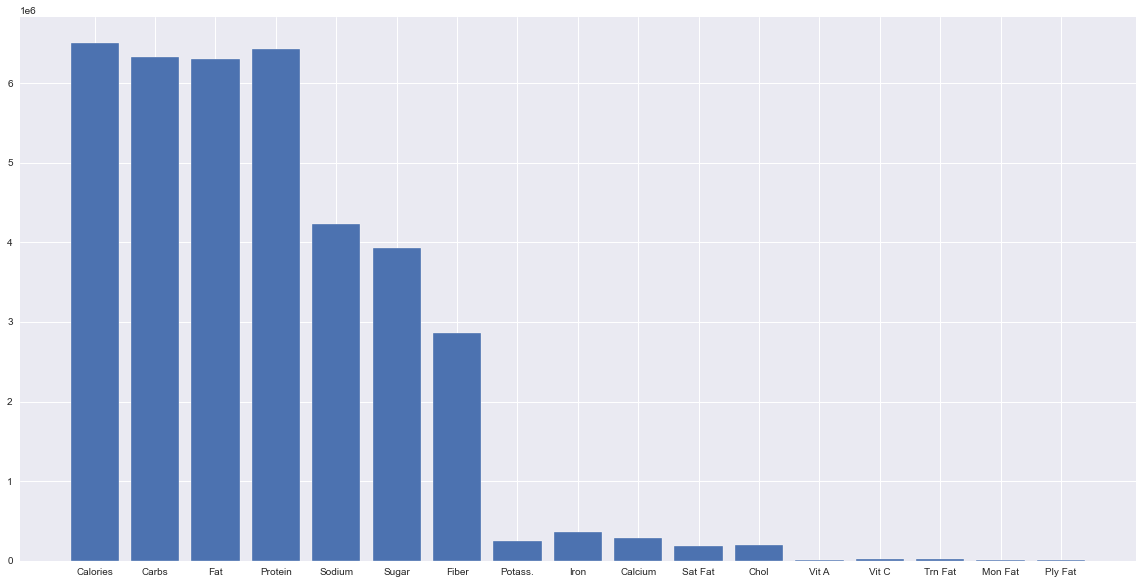

In [11]:
with plt.style.context('seaborn'):
    plt.figure(figsize = (20, 10))
    plt.bar(unique_nutritions.keys(), unique_nutritions.values());

As we can see, we have 17 different nutritions, but not all of them are specified by users in every food entry, let's find out exactly how many are specified by user for each food.

In [12]:
def get_entered_nutritions_counts():
    unique_nutritions_counts = defaultdict(int)
    dataset['food_entries'].apply(get_counts_from_row, args = [unique_nutritions_counts])
    return unique_nutritions_counts

def get_counts_from_row(row, unique_counts):
    food_entries = js.loads(row)
    for entry in food_entries:
        for dish in entry['dishes']:
            unique_counts[str(len(dish['nutritions']))] += 1
            if unique_counts[str(len(dish['nutritions']))] == 1:
                print(dish['name'])
                for nutrition in dish['nutritions']:
                    print(nutrition)
                print('----------------------------------------------------------')

In [13]:
unique_counts = get_entered_nutritions_counts()
print('Unique nutritions count:', len(unique_counts))
unique_counts

my - McDonalds Espresso Pronto® Flat White, 2 TALL
{'name': 'Calories', 'value': '412'}
{'name': 'Carbs', 'value': '29'}
{'name': 'Fat', 'value': '24'}
{'name': 'Protein', 'value': '21'}
{'name': 'Sodium', 'value': '258'}
{'name': 'Sugar', 'value': '29'}
----------------------------------------------------------
Updated Chobani Greek Yogurt - Vanilla Non-fat, 5.3 oz 150g
{'name': 'Calories', 'value': '120'}
{'name': 'Carbs', 'value': '16'}
{'name': 'Fat', 'value': '0'}
{'name': 'Protein', 'value': '13'}
----------------------------------------------------------
Sainsbury's - Organic Kiwi Fruit, 1 fruit (80g)
{'name': 'Calories', 'value': '41'}
{'name': 'Carbs', 'value': '11'}
{'name': 'Fat', 'value': '0'}
{'name': 'Protein', 'value': '1'}
{'name': 'Fiber', 'value': '2'}
----------------------------------------------------------
Taco Bell - California Am Crunchwrap, 188 g
{'name': 'Calories', 'value': '504'}
{'name': 'Protein', 'value': '18'}
{'name': 'Carbs', 'value': '42'}
-----------

defaultdict(int,
            {'6': 5763049,
             '4': 255716,
             '5': 460668,
             '3': 5895,
             '1': 13342,
             '2': 4077})

From this check we can infer that count of nutritions entered defining food can be from 1 to 6. 

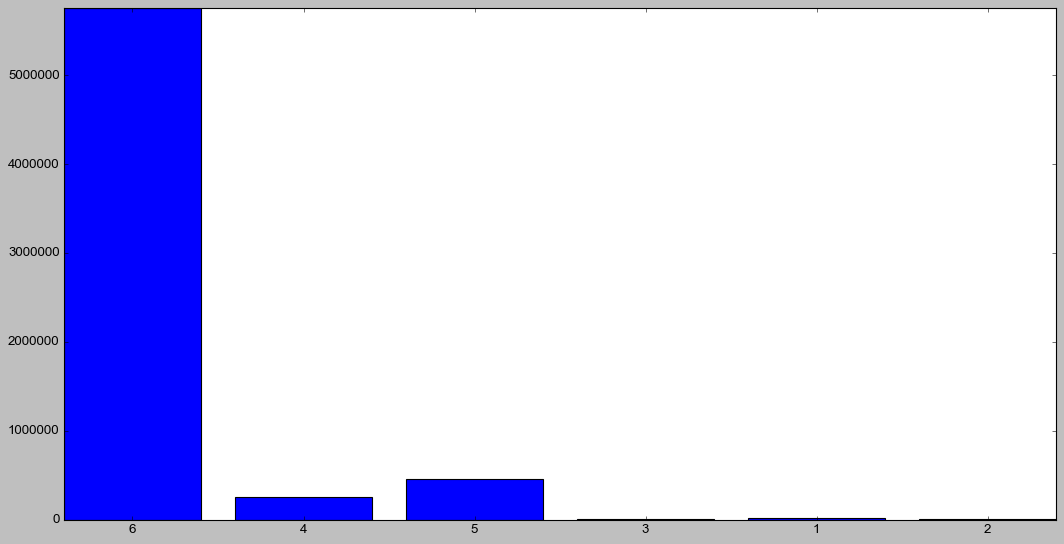

In [14]:
with plt.style.context('classic'):
    plt.figure(figsize = (16, 8))
    plt.bar(unique_counts.keys(), unique_counts.values());

We can see that almost 90% of food is entered with 6 defining nutritions. Which is quite nice, because more information is always good for us. Also, 7% is entered with 5 defining nutritions and almost 4% - with 4 defining nutritions. Other quanities don't even amount to 0.4 percent. 

<h2>Food</h2>

Now let's define some useful functions to check how many different types of food we have in our dataset.

In [15]:
def get_unique_food():
    unique_food = defaultdict(int)
    dataset['food_entries'].apply(get_food_from_row, args = [unique_food])
    return unique_food

def get_food_from_row(row, unique_food):
    food_entries = js.loads(row)
    for food_entry in food_entries:
        dishes = food_entry['dishes']
        for dish in dishes:
                unique_food[dish['name']] += 1

In [16]:
unique_food = get_unique_food()
print("Unique food count:", len(unique_food))

Unique food count: 1461367


Now, let's sort and check first and last 15 food by count.

In [17]:
def print_sorted_food(count, order):
    sorted_unique_food = sorted(unique_food, key = unique_food.get, reverse = order)

    for i in range(count):
        food = sorted_unique_food[i]
        print(str(i + 1) + ('. ' if i < 9 else '.'), food, (85 - len(food)) * '-', unique_food[food])

In [18]:
print_sorted_food(15, True)

1.  Coffee - Brewed from grounds, 2 cup (8 fl oz) ---------------------------------------- 21011
2.  Coffee - Brewed from grounds, 1 cup (8 fl oz) ---------------------------------------- 19888
3.  Bananas - Raw, 1 medium (7" to 7-7/8" long) ------------------------------------------ 11256
4.  Spinach - Raw, 1 cup ----------------------------------------------------------------- 7251
5.  Coffee - Brewed from grounds, 3 cup (8 fl oz) ---------------------------------------- 7206
6.  Cucumber - With peel, raw, 0.5 cup slices -------------------------------------------- 5370
7.  Eggs - Fried (whole egg), 1 large ---------------------------------------------------- 4858
8.  Eggs - Fried (whole egg), 2 large ---------------------------------------------------- 4775
9.  Apples - Raw, with skin, 1 medium (2-3/4" dia) (approx 3 per lb) --------------------- 4652
10. Coffee - Brewed from grounds, 4 cup (8 fl oz) ---------------------------------------- 4450
11. Bananas - Raw, 1 small (6" to 6-7

In [19]:
print_sorted_food(15, False)

1.  Grilld - Simply Grilled (Real), 1.25 burger ------------------------------------------ 1
2.  Sainsbury's - Italian - Spaghetti Carbonara, 300 g ----------------------------------- 1
3.  Beans Green - Boiled, 50 g ----------------------------------------------------------- 1
4.  Mao - Seafood Laksa, 1 bowl ---------------------------------------------------------- 1
5.  Dickey's - Big Bbq Sandwich, 6 oz ---------------------------------------------------- 1
6.  Dickey's Bbq - Mac & Cheese, 4 oz. --------------------------------------------------- 1
7.  Dickey's Bbq Pit - Spicy Cheddar Sausage, 4 oz --------------------------------------- 1
8.  Peroni - Nastro Azzuro - Pale Lager 5.1, 2 bottle or can ----------------------------- 1
9.  Generic - Fruit Salad, 3 CUP --------------------------------------------------------- 1
10. 12wbt - Spinach and Ricotta Cannelloni, 1 serve -------------------------------------- 1
11. Trader Joe's - Linguini With Clam Sauce, 4 cup cooked ------------

As we can notice, there are food that are entered only once. Let's check how many similar cases are there.

In [20]:
sorted_unique_food = sorted(unique_food, key = unique_food.get, reverse = False)

count = 0
while unique_food[sorted_unique_food[count]] == 1:
    count += 1

print('Count of food entered only once:', count)

Count of food entered only once: 820629


Around `56%` of unique foods are entered only once, that can be attributed to the fact that users are entering food names on their own and there may be many typos.

It will be interesting to find out actually how many of them are really entered only once. We might check it later.

<h1><span style="color:blue">Creating Food Dataframe</span></h1>

Let's create dataframe specially for foods, where each food will have it's corresponding nutritions.

<h3>Helper functions:</h3>

In [21]:
def string_to_int(x):
    return int(x.replace(',', ''))

In [22]:
def transform_to_dataframe_helper(x, food_data):
    food_entries = js.loads(x)
    for entry in food_entries:
        dishes = entry['dishes']
        for dish in dishes:
            row = {'Name': dish['name'], 'Calcium': 0, 'Ply Fat': 0, 'Carbs': 0, 'Chol': 0, 'Fiber': 0, 'Protein': 0, 'Calories': 0, 'Trn Fat': 0, 'Fat': 0, 'Potass.': 0, 'Iron': 0, 'Sat Fat': 0, 'Vit A': 0, 'Sodium': 0, 'Vit C': 0, 'Sugar': 0, 'Mon Fat': 0}
            for nutrition in dish['nutritions']:
                row[nutrition['name']] = string_to_int(nutrition['value'])
            food_data.append(row)

<h3>Transforming to food dataframe:</h3>

Following code is for creating dataframe, filtering out duplicates and adding them as new count column to unique entries. This code will be commented hence we save result dataframe and load it not to create it on every run.

In [23]:
# food_data = []
# dataset['food_entries'].apply(transform_to_dataframe_helper, args = [food_data])
# food_df = pd.DataFrame(food_data)

Now, let's filter out duplicates and also add count of each unique entry as new column.

In [24]:
# food_df = food_df.value_counts().to_frame()
# food_df.rename(columns = {0: 'Count'}, inplace = True)
# food_df.reset_index(inplace = True)
# food_df.head()

Finally, save our dataframe.

In [25]:
# food_df.to_csv('food_df.csv')

And load it.

In [26]:
food_df = pd.read_csv('food_df.csv')
food_df.drop(food_df.columns[0], inplace = True, axis = 1)
food_df.head()

Name  Calcium  Ply Fat  Carbs  \
0  Coffee - Brewed from grounds, 2 cup (8 fl oz)        0        0      0   
1  Coffee - Brewed from grounds, 1 cup (8 fl oz)        0        0      0   
2  Coffee - Brewed from grounds, 1 cup (8 fl oz)        0        0      0   
3  Coffee - Brewed from grounds, 2 cup (8 fl oz)        0        0      0   
4  Coffee - Brewed from grounds, 3 cup (8 fl oz)        0        0      0   

   Chol  Fiber  Protein  Calories  Trn Fat  Fat  Potass.  Iron  Sat Fat  \
0     0      0        1         5        0    0        0     0        0   
1     0      0        0         2        0    0        0     0        0   
2     0      0        0         2        0    0        0     0        0   
3     0      0        1         5        0    0        0     0        0   
4     0      0        1         7        0    0        0     0        0   

   Vit A  Sodium  Vit C  Sugar  Mon Fat  Count  
0      0       9      0      0        0  13535  
1      0       5      0      0        0  11792  
2      0       0      0      0        0   6947  
3      0       0      0      0        0   5335  
4      0      14      0      0        0   4504

In [27]:
food_df.shape

(1984590, 19)

Since we have food dataframe we can check distributions of nutritions in our data.

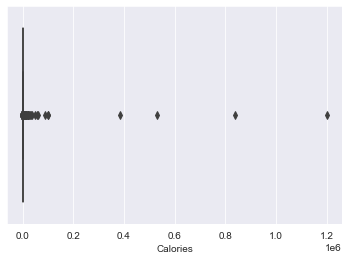

In [28]:
sb.boxplot(x = 'Calories', data = food_df);

It seems there are outliers that are spoiling the plots and data. They should be taken care of. For example:

In [29]:
food_df[food_df['Calories'] >= 30000]

Name  Calcium  Ply Fat  \
145113                            I'm Fat - Yolo, 10000 oz        0        0   
734820               Quick Added Calories, 60,000 calories        0        0   
913826   Brachs - Candy Corn....kim, 400 container (285...        0        0   
942580   Caitlyn - Smoothie 13 2banana1EnglishCucumber2...        0        0   
1226701                       Complan - multi grain, 1 cup        0        0   
1242466                  Sierra Nevada - Pale Ale, 6000 oz        0        0   
1361957                   Potato - Steamed Potato, 57300 g        0        0   
1404125              Quick Added Calories, 99,999 calories        0        0   
1629175   Kerrygold - Butter, Pure Irish, 168112 g (1Tbsp)        0        0   
1690682  Kirkland Signature - Greek Yogurt (Grams), 226...     5650        0   
1962536  Mcdonalds - Double Quarter Pounder With Cheese...        0        0   
1970773       Mcdonald's - Mcdonald Big Mac, 1000 Sandwich        0        0   

          Carbs  Chol  Fiber  Protein  Calories  Trn Fat     Fat  Potass.  \
145113    10000     0   1000    10000    100000        0   10000        0   
734820        0     0      0        0     60000        0       0        0   
913826   210000     0      0        0    840000        0       0        0   
942580        0     0      0        0    385024        0       0        0   
1226701     108     0      0        8     37400        0       2        0   
1242466    7050     0      0      750     87500        0       0        0   
1361957   11460     0      0      974     49278        0       0        0   
1404125       0     0      0        0     99999        0       0        0   
1629175       0     0      0        0   1200800        0  132088        0   
1690682    2260     0      0     5424     31640        0       0        0   
1962536     500     0      0     4300     55000        0    4000        0   
1970773   47000     0   3000        0    530000        0       0        0   

         Iron  Sat Fat  Vit A  Sodium  Vit C   Sugar  Mon Fat  Count  
145113      0        0      0       0      0       0        0      7  
734820      0        0      0       0      0       0        0      2  
913826      0        0      0  420000      0  168000        0      1  
942580      0        0      0       0      0       0        0      1  
1226701     0        0      0       0      0       0        0      1  
1242466     0        0      0    7000      0       0        0      1  
1361957     0        0      0       0      0     478        0      1  
1404125     0        0      0       0      0       0        0      1  
1629175     0        0      0       0      0       0        0      1  
1690682     0        0      0   21470      0       0        0      1  
1962536     0        0      0   85000      0     100        0      1  
1970773     0        0      0  960000      0    9000        0      1

Those are definitely abnormal entries, some of them are typos, some of them are users being unserious. Anyway, those entries should be removed because they are polluting our data.

<h1><span style="color:blue">Removing Outliers With IQR</span></h1>

To remove outliers we should get a better understanding of our data and it's distribution. To do this we will use `Interquartile range (IQR) method`. The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot. The IQR defines the middle 50% of the data, or the body of the data. The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots.

<h3>Helper functions:</h3>

In [30]:
def get_quartiles(food_df, column_names):
    quartiles = dict()
    for column_name in column_names:
        curr_Q1 = food_df[food_df[column_name] != 0][column_name].quantile(0.25)
        curr_Q3 = food_df[food_df[column_name] != 0][column_name].quantile(0.75)
        curr_IQR = curr_Q3 - curr_Q1
        quartiles[column_name] = (curr_Q1, curr_IQR, curr_Q3)
    return quartiles

In [31]:
def get_indices_to_remove(food_df, column_names):
    removed_indices = dict()
    for column_name in column_names:
        index = food_df.index
        Q1 = quartiles[column_name][0]
        IQR = quartiles[column_name][1]
        Q3 = quartiles[column_name][2]
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        if lower_bound < 0:
            lower_bound = 0
        condition = np.logical_or(food_df[column_name] < lower_bound, food_df[column_name] > upper_bound)
        indices = list(index[condition])
        removed_indices[column_name] = indices
    return removed_indices

In [32]:
def filter_indices_to_remove(indices_to_remove, values_to_remove, threshold):
    filtered_indices = set()
    for i, index in enumerate(indices_to_remove):
        if values_to_remove[i] >= 0:
            break
        filtered_indices.add(index)
    for i, index in reversed(list(enumerate(indices_to_remove))):
        if values_to_remove[i] <= threshold:
            break
        filtered_indices.add(index)
    return filtered_indices

<h3>Applying IQR:</h3>

In [33]:
column_names = list(unique_nutritions.keys())
#Q1 - quartiles[column_name][0]
#IQR - quartiles[column_name][1]
#Q3 - quartiles[column_name][2]
quartiles = get_quartiles(food_df, column_names)
quartiles

{'Calories': (60.0, 170.0, 230.0),
 'Carbs': (5.0, 24.0, 29.0),
 'Fat': (3.0, 9.0, 12.0),
 'Protein': (2.0, 12.0, 14.0),
 'Sodium': (50.0, 370.0, 420.0),
 'Sugar': (2.0, 9.0, 11.0),
 'Fiber': (1.0, 3.0, 4.0),
 'Potass.': (79.0, 280.0, 359.0),
 'Iron': (2.0, 8.0, 10.0),
 'Calcium': (2.0, 10.0, 12.0),
 'Sat Fat': (1.0, 4.0, 5.0),
 'Chol': (11.0, 57.0, 68.0),
 'Vit A': (2.0, 18.0, 20.0),
 'Vit C': (4.0, 34.0, 38.0),
 'Trn Fat': (1.0, 1.0, 2.0),
 'Mon Fat': (1.0, 5.0, 6.0),
 'Ply Fat': (1.0, 2.0, 3.0)}

Now that we have Q1, IQR and Q3 scores for each nutrition column, we can get closer look at what are considered to be outliers by IQR method.

In [34]:
indices_to_remove = get_indices_to_remove(food_df, column_names)

In [35]:
unique_indices_to_remove = set()
for column in indices_to_remove:
    unique_indices_to_remove = unique_indices_to_remove.union(set(indices_to_remove[column])) 
print('Number of unique elements to remove:', len(unique_indices_to_remove))

Number of unique elements to remove: 331056


331056 is almost 17% of our data and it is a bit too much. We will have to look at those ourselves and see what is going on. First, let's sort indices by corresponding values for each column and also make new dict containing values.

In [36]:
values_to_remove = dict()
for column_name in column_names:
    indices_to_remove[column_name].sort(key = lambda elem: food_df.iloc[elem, food_df.columns.get_loc(column_name)])
    values_to_remove[column_name] = list(map(lambda elem: food_df.iloc[elem, food_df.columns.get_loc(column_name)],
                                             indices_to_remove[column_name]))

Now, that we have our data in the way we want, let's take calories for example and look into more details.

<h4>Calories:<h4>

In [37]:
len(indices_to_remove['Calories'])

109002

We can see that IQR method tells us that there are 109 thousand outliers just from calories. Let's look at how they are distributed.

In [38]:
print(values_to_remove['Calories'])

[-750, -620, -600, -500, -500, -500, -500, -500, -500, -500, -500, -500, -500, -500, -500, -400, -400, -400, -400, -397, -375, -370, -333, -333, -300, -300, -300, -300, -300, -300, -252, -250, -250, -250, -250, -220, -200, -200, -200, -200, -200, -189, -186, -170, -165, -140, -125, -123, -100, -100, -95, -90, -86, -84, -81, -76, -74, -70, -68, -66, -66, -66, -64, -64, -62, -60, -60, -60, -60, -60, -60, -58, -56, -54, -54, -52, -50, -48, -48, -46, -46, -44, -44, -44, -43, -42, -40, -40, -40, -40, -38, -34, -28, -25, -25, -21, -20, -20, -16, -15, -5, -4, -3, -1, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486, 486

First thing that catches our eye is that there are foods with negative calories. Let's observe them more closely.

In [39]:
print(food_df.iloc[indices_to_remove['Calories'][0]])
print("---------------------------------------------------------")
print(food_df.iloc[indices_to_remove['Calories'][40]])

Name        Generic - Breastfeeding Exclusively, 40.5 oz.
Calcium                                                 0
Ply Fat                                                 0
Carbs                                                 -75
Chol                                                    0
Fiber                                                   0
Protein                                               -47
Calories                                             -750
Trn Fat                                                 0
Fat                                                   -24
Potass.                                                 0
Iron                                                    0
Sat Fat                                                 0
Vit A                                                   0
Sodium                                                  0
Vit C                                                   0
Sugar                                                   0
Mon Fat       

We can see that these are not foods, so it is perfectly fine to remove these types of entries from our food database.

After this we can notice that IQR method says that food with 486 calories is an outlier. But it is very normal for food to have 486 calories, for example, 1 large McDonald's French Fries is 500 calories. So, as suspected, IQR method doesn't filter out outliers very well and we have to interfere manually. At this point it would be good to employ help of expert in this sphere. But for now let's do this ourselves.

After some research, of which we shall not go into details (it involved lot of googling food compositions in general and also comparing it to our data), it was decided that maximal calories for one dish should be 1500 and everything above that is an outlier and should be removed.

In [40]:
updated_indices_to_remove = dict()

In [41]:
updated_indices_to_remove['Calories'] = filter_indices_to_remove(indices_to_remove['Calories'], values_to_remove['Calories'], 1500)
print('Calories', '------------------------------------------', 'Deleted:', len(updated_indices_to_remove['Calories']), '/', len(indices_to_remove['Calories']))

Calories ------------------------------------------ Deleted: 2018 / 109002


Now that we have indices of elements that we acknoweldge as outliers of calories, we can move on to next nutritions.

<h4>Carbs, Fat, Protein, Sodium, Sugar, Fiber, Potass., Iron, Calcium, Sat Fat, Chol, Vit A, Vit C, Trn Fat, Mon Fat, Ply Fat:</h4>

We won't go into every step of outlier removal process for every nutrition. They are same as for calories.
Thresholds list contains decided individual thresholds for respective nutritions.

In [42]:
nutritions_without_calories = ['Carbs', 'Fat', 'Protein', 'Sodium', 'Sugar', 'Fiber', 'Potass.', 'Iron', 'Calcium', 'Sat Fat', 'Chol', 'Vit A', 'Vit C', 'Trn Fat', 'Mon Fat', 'Ply Fat']
thresholds = [250, 120, 95, 4600, 150, 39, 1800, 100, 106, 35, 650, 500, 300, 16, 20, 14]

In [43]:
for i in range(len(nutritions_without_calories)):
    nutrition_name = nutritions_without_calories[i]
    nutrition_threshold = thresholds[i]
    
    updated_indices_to_remove[nutrition_name] = filter_indices_to_remove(indices_to_remove[nutrition_name], values_to_remove[nutrition_name], nutrition_threshold)
    print(nutrition_name, (50 - len(nutrition_name)) * '-', 'Deleted:', len(updated_indices_to_remove[nutrition_name]), '/', len(indices_to_remove[nutrition_name]))

Carbs --------------------------------------------- Deleted: 802 / 74023
Fat ----------------------------------------------- Deleted: 959 / 95512
Protein ------------------------------------------- Deleted: 2589 / 111226
Sodium -------------------------------------------- Deleted: 702 / 78178
Sugar --------------------------------------------- Deleted: 446 / 58462
Fiber --------------------------------------------- Deleted: 400 / 28127
Potass. ------------------------------------------- Deleted: 146 / 2098
Iron ---------------------------------------------- Deleted: 207 / 5615
Calcium ------------------------------------------- Deleted: 219 / 5050
Sat Fat ------------------------------------------- Deleted: 79 / 2251
Chol ---------------------------------------------- Deleted: 114 / 2378
Vit A --------------------------------------------- Deleted: 16 / 247
Vit C --------------------------------------------- Deleted: 50 / 385
Trn Fat ------------------------------------------- Deleted: 

<h3>Deleting outliers:</h3>

In [44]:
updated_unique_indices_to_remove = set()
for indices in updated_indices_to_remove.values():
    updated_unique_indices_to_remove = updated_unique_indices_to_remove.union(indices)
updated_unique_indices_to_remove = list(updated_unique_indices_to_remove)

In [45]:
print('Number of outliers:', len(updated_unique_indices_to_remove))

Number of outliers: 6958


It looks like from our observations that 0.35% of our data were outliers, let's delete them from dataframe.

In [46]:
deleted_data = food_df.loc[updated_unique_indices_to_remove, : ]

In [47]:
food_df.drop(updated_unique_indices_to_remove, inplace = True) 
food_df.reset_index(inplace = True, drop = True)

Let us double check and double filter our results with another method of detecting outliers. We shall check it with projection method.

<h1><span style="color:blue">Removing Outliers With Projection Method</span></h1>

Projection methods are relatively simple to apply and quickly highlight extraneous values.

- Use projection methods to summarize your data to two dimensions (such as PCA, SOM or Sammon’s mapping);
- Visualize the mapping and identify outliers by hand.

We shall use PCA for reducing dimensionality. Also it will help us identify outliers with multivariate method.

<h3>Standartizing the data:</h3>

For PCA to function well, it is neccessary that data is standartized. It is even more important for our data because aside from having different variances, not everything is measured in same measurements, e.g. grams.

In [48]:
nutrition_values = food_df.iloc[:, 1:18].values
nutrition_values = StandardScaler().fit_transform(nutrition_values)

<h3>Using PCA:</h3>

In [49]:
pca = PCA(n_components = 2, svd_solver = 'full')
data_2D = pca.fit_transform(nutrition_values)

In [50]:
pca_df = pd.DataFrame(data = data_2D, columns = ['Principal Component 1', 'Principal Component 2'])
pca_df.head()

Principal Component 1  Principal Component 2
0              -1.705750               0.198707
1              -1.752636               0.165696
2              -1.757540               0.163599
3              -1.714576               0.194931
4              -1.694233               0.200698

In [51]:
sum(pca.explained_variance_ratio_)

0.24688894506824655

Having only 25% of variance retained is probably bad, but we don't know exactly how bad it is. So, we have 2 options:
- Don't use this method at all, because it might be bad;
- Or we can still use this method, but be more careful and don't delete much.

Let's go through with second option. 

<h3>Visualizing data:</h3>

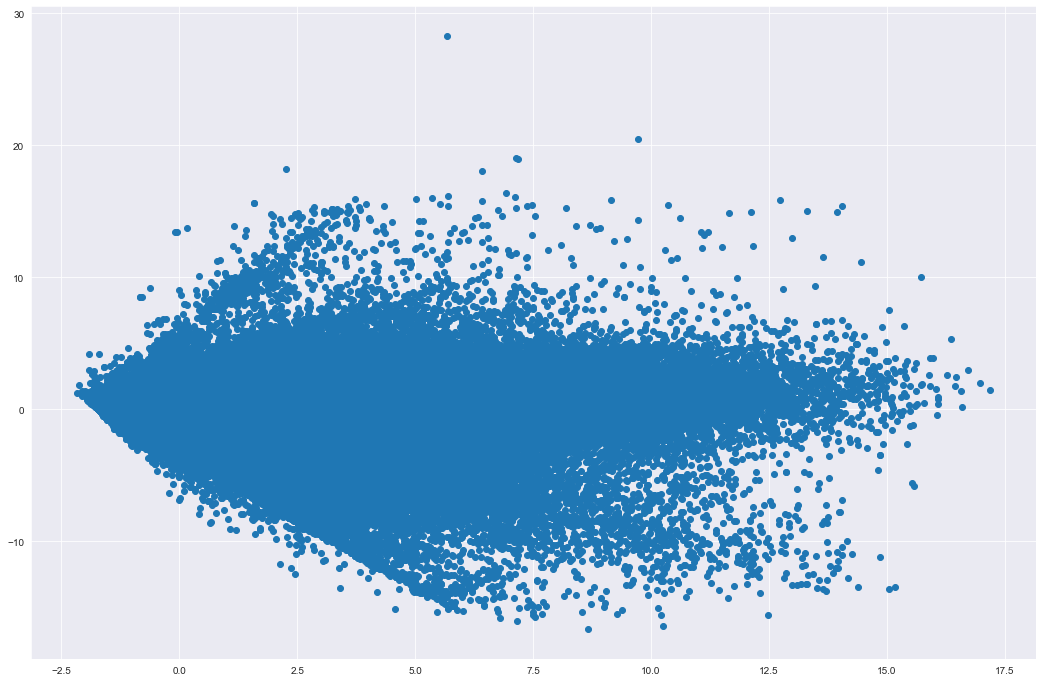

In [52]:
plt.figure(figsize = (18, 12))
plt.scatter(data_2D[:, 0], data_2D[:, 1]);

# For 3D plot
# fig = plt.figure(figsize = (25, 25))
# ax = plt.axes(projection = '3d')
# scatter = ax.scatter(data_2D[:, 0], data_2D[:, 1], data_2D[:, 2])
# plt.show()

Now let's draw some red lines for what we think are outliers. Everything that is outside of any red line will be considered as outlier.

In [53]:
# Points of lines that will set borders for outliers
x1_1, y1_1, x2_1, y2_1 = -2.5, 20, 16.2, 8
x1_2, y1_2, x2_2, y2_2 = -2.5, -22.7, 16.2, -11
x1_3, y1_3, x2_3, y2_3 = 13, -20, 16.2, 0
x1_4, y1_4, x2_4, y2_4 = 12, 20, 16.6, 0
x1_5, y1_5, x2_5, y2_5 = -2.5, 2, 5, 25

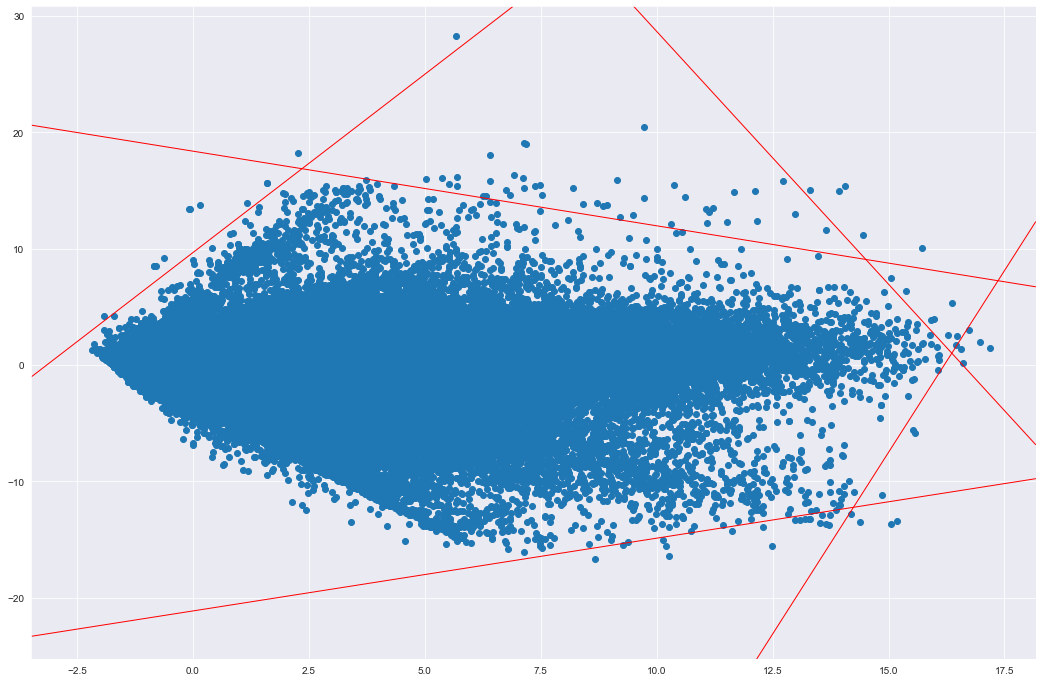

In [54]:
plt.figure(figsize = (18, 12))
plt.axline((x1_1, y1_1), (x2_1, y2_1), linewidth = 1, color = 'r')
plt.axline((x1_2, y1_2), (x2_2, y2_2), linewidth = 1, color = 'r')
plt.axline((x1_3, y1_3), (x2_3, y2_3), linewidth = 1, color = 'r')
plt.axline((x1_4, y1_4), (x2_4, y2_4), linewidth = 1, color = 'r')
plt.axline((x1_5, y1_5), (x2_5, y2_5), linewidth = 1, color = 'r')
plt.scatter(data_2D[:, 0], data_2D[:, 1]);

In [55]:
# This function will return k and b coefficients of the linear function that contains given coordinates
def get_k_and_b(x1, y1, x2, y2):
    k = (y2 - y1) / (x2 - x1)
    b = y1 - k * x1
    return k, b

In [56]:
filtered_indices = []

# Get k and b for each line
k1, b1 = get_k_and_b(x1_1, y1_1, x2_1, y2_1)
k2, b2 = get_k_and_b(x1_2, y1_2, x2_2, y2_2)
k3, b3 = get_k_and_b(x1_3, y1_3, x2_3, y2_3)
k4, b4 = get_k_and_b(x1_4, y1_4, x2_4, y2_4)
k5, b5 = get_k_and_b(x1_5, y1_5, x2_5, y2_5)

Now, let's filter all points and remember outliers.

In [57]:
for row in pca_df.itertuples():
    x = row._1
    y = row._2
    
    y1 = k1 * x + b1
    y2 = k2 * x + b2
    y3 = k3 * x + b3
    y4 = k4 * x + b4
    y5 = k5 * x + b5
    
    if (y >= y1) or (y <= y2) or (y <= y3) or (y >= y4) or (y >= y5):
        filtered_indices.append(row.Index)

In [58]:
print('Count of outliers found with PCA:', len(filtered_indices))

Count of outliers found with PCA: 99


<h3>Deleting outliers:</h3>

In [59]:
deleted_data_with_pca = food_df.loc[filtered_indices, :]
food_df.drop(filtered_indices, inplace = True)
food_df.reset_index(inplace = True, drop = True)

At the end, we can take a look at removed outliers. 

In [60]:
deleted_data = pd.concat([deleted_data, deleted_data_with_pca])
deleted_data

Name  Calcium  Ply Fat  \
1294336                           Sugars - Brown, 233.33 g        0        0   
1851393  Papa Johns - Pizza - Medium Peperoni and Sausa...        0        0   
1392645   Sa - Spare Rib Pizza, 1 container (8 slices ea.)        0        0   
1851397  Papa Johns - Pizza - Medium Peperoni and Sausa...        0        0   
671751   Thr1ve - Chicken Bowl - Main Size (Jan 2015), ...        0        0   
...                                                    ...      ...      ...   
1954372                  Mcdonalds - Big Breakfast, 9.5 oz        0        0   
1955766  Mcdonald's - Sausage Egg Mcmuffin (Canada), 2 ...        0        0   
1955969  Mcdonald's - Sausage Mcmuffin With Egg, 2 sand...        0        0   
1969579                         Migas 121614, 1 serving(s)        0        0   
1974293                Meathead Ice Cream #2, 2 serving(s)        0        0   

         Carbs  Chol  Fiber  Protein  Calories  Trn Fat  Fat  Potass.  Iron  \
1294336    227     0      0        0       880        0    0        0     0   
1851393    208     0      0       72      1840        0   72        0     0   
1392645     14     0      0      138      2831        0  154        0     0   
1851397    182     0      0       63      1610        0   63        0     0   
671751       7     0      0       44       503        0   33        0     0   
...        ...   ...    ...      ...       ...      ...  ...      ...   ...   
1954372     51   555      0       28       740        0   48        0     0   
1955766     64   440      0       40       880        0   52        0     0   
1955969     60   570      4        0       900        0   54        0     0   
1969579     29   622      0       37       601        0   36        0     0   
1974293     34   644      0       20       649        0   49        0     0   

         Sat Fat  Vit A  Sodium  Vit C  Sugar  Mon Fat  Count  
1294336        0      0       0      0    224        0      1  
1851393        0      0    4640      0     24        0      1  
1392645        0      0    3796      0      0        0      1  
1851397        0      0    4060      0     21        0      1  
671751         0      0    4683      0      3        0      2  
...          ...    ...     ...    ...    ...      ...    ...  
1954372        0      0    1560      0      0        0      1  
1955766       20      0       0      0      0        0      1  
1955969        0      0    1840      0      0        0      1  
1969579        0      0    1070      0      0        0      1  
1974293        0      0     290      0      0        0      1  

[7057 rows x 19 columns]

<h1><span style="color:blue">Collating Food Entries</span></h1>

In [61]:
food_df.head()

Name  Calcium  Ply Fat  Carbs  \
0  Coffee - Brewed from grounds, 2 cup (8 fl oz)        0        0      0   
1  Coffee - Brewed from grounds, 1 cup (8 fl oz)        0        0      0   
2  Coffee - Brewed from grounds, 1 cup (8 fl oz)        0        0      0   
3  Coffee - Brewed from grounds, 2 cup (8 fl oz)        0        0      0   
4  Coffee - Brewed from grounds, 3 cup (8 fl oz)        0        0      0   

   Chol  Fiber  Protein  Calories  Trn Fat  Fat  Potass.  Iron  Sat Fat  \
0     0      0        1         5        0    0        0     0        0   
1     0      0        0         2        0    0        0     0        0   
2     0      0        0         2        0    0        0     0        0   
3     0      0        1         5        0    0        0     0        0   
4     0      0        1         7        0    0        0     0        0   

   Vit A  Sodium  Vit C  Sugar  Mon Fat  Count  
0      0       9      0      0        0  13535  
1      0       5      0      0        0  11792  
2      0       0      0      0        0   6947  
3      0       0      0      0        0   5335  
4      0      14      0      0        0   4504

As we can see in our dataset there are same foods with different amounts of nutritions. This can be caused by different reasons:
- Users enter nutritions that they are observing (for example, someone is interested only in `calories`/`sugar` and doesn't care about other nutritions that food consists of);
- As we have seen above, we don't have more than 6 nutritions entered, and that's probably because there is a limit of six entries and user can't enter every nutrition that food consists of. So, exact nutritional consistency can be scattered across multiple entries;
- Or, simply, there may be typos.

Because of this reasons majority of food appears several times in our dataset. To treat all this issues we can simply merge all different entries of same food into one, with logic that follows:

Our goal is to not have zero values in any column, for this we shall replace them if possible.

- First of all, let's calculate non-zero mode;
    - If frequency of mode is more than 1/5 of non-zero entries, we can assume that real value of that nutrition is exactly this calculated mode.
    - If frequency of mode is less than 1/5 of non-zero entries, there might be two cases:
        - Real value is zero and there are some typos, that can be assumed if more than 80% of entries are zeroes. In this case we shall replace other non-zero entries with zeroes;
        - There are multiple candidates of being real value, and they are close to each other by quantities. In this case we shall replace everything with the average value of non-zero entries.

In [62]:
def column_function(column, count, output_row):
    total_count = sum(count)
    
    if column.name == 'Count':
        output_row.append(total_count)
        return
    
    value_counts = defaultdict(int)
    for index, value in column.iteritems():
        value_counts[value] += count[index]
    
    values = sorted(value_counts, key = value_counts.get, reverse = True)
    
    #If we have only 1 value, we dont change anything
    if len(values) > 1:
        non_zero_count = total_count - value_counts[0]

        mode = values[0]
        # We need non-zero mode
        if mode == 0:
            mode = values[1]

        replace_value = mode # If mode is more than 0.2, values must be replaced with mode
        if value_counts[mode] / non_zero_count < 0.2 or value_counts[mode] < 3:
            replace_value = 0 # If zero percentage is more than 0.8, values must be replaced with zero
            if value_counts[0] / total_count < 0.8:
                # In this case values must be replaced with average
                replace_value = sum(column) / non_zero_count
        output_row.append(replace_value)
    else:
        output_row.append(values[0])

In [63]:
def group_function(group_df):
    row = []
    group_df.apply(column_function, axis = 0, count = group_df['Count'], output_row = row)
    return pd.DataFrame(data = [row], columns = food_df.columns)

To be honest, writing and running above functions took us several days and we aren't going to run them again, ever. So, we strictly decided to save the output as CSV and load it on every run. In addition, running this function is not advisable, since it takes up to 2 hours of execution time, but previous 15 versions took much more (:D).

In [64]:
# unique_food_df = food_df.groupby('Name', sort = False).apply(group_function)

In [65]:
# unique_food_df.to_csv('unique_food_df.csv')

In [66]:
food_df = pd.read_csv('unique_food_df.csv')
food_df.drop([food_df.columns[1], food_df.columns[2]], inplace = True, axis = 1)
food_df.head()

Name  Calcium  Ply Fat  Carbs  \
0  Coffee - Brewed from grounds, 2 cup (8 fl oz)      1.0      0.0    0.0   
1  Coffee - Brewed from grounds, 1 cup (8 fl oz)      0.0      0.0    0.0   
2  Coffee - Brewed from grounds, 3 cup (8 fl oz)      1.0      0.0    0.0   
3                           Spinach - Raw, 1 cup      3.0      0.0    1.0   
4              Eggs - Fried (whole egg), 1 large      3.0      0.0    0.0   

    Chol  Fiber  Protein  Calories  Trn Fat  Fat  Potass.  Iron  Sat Fat  \
0    0.0    0.0      1.0       5.0      0.0  0.0    232.0   0.0      0.0   
1    0.0    0.0      0.0       2.0      0.0  0.0    116.0   0.0      0.0   
2    0.0    0.0      1.0       7.0      0.0  0.0    348.0   0.0      0.0   
3    0.0    1.0      1.0       7.0      0.0  0.0    167.0   5.0      0.0   
4  210.0    0.0      6.0      92.0      0.0  7.0     68.0   5.0      2.0   

   Vit A  Sodium  Vit C  Sugar  Mon Fat  Count  
0    0.0     9.0    0.0    0.0      0.0  21011  
1    0.0     5.0    0.0    0.0      0.0  19888  
2    0.0    14.0    0.0    0.0      0.0   7206  
3   56.0    24.0   14.0    0.0      0.0   7251  
4    7.0    94.0    0.0    0.0      0.0   4858

Finally, our data looks like it's pretty clean. We reached our goal of having one unique entry for each food, that consists of collated data of multiple entries. We can look and check that it worked fine, since we have three different portions of `Coffee - Brewed from grounds`, each of them are unique and they are correlated with each others sizes (2 cup portion's nutritions are twice greater than 1 cup portion's nutritions, and 3 cup portion's nutritions are three times greater than 1 cup portion's nutritions). And same goes for almost every other entry.

<h1><span style="color:blue">EDA (Exploratory Data Analysis)</span></h1>

Now that we have our data how we want it, it will be pretty interesting to explore more details and truly see what we have to work with. Let's start with univariate analysis.

<h2>Univariate Analysis</h2>

<h3>Calcium:</h3>

In [67]:
column_name = 'Calcium'

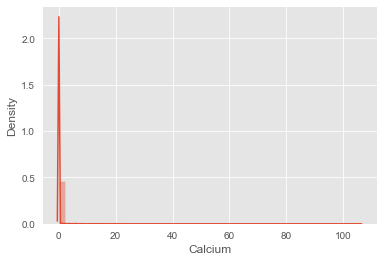

In [68]:
with plt.style.context('ggplot'):
    sb.distplot(food_df[column_name]);

This plot looks pretty bad, let's check why is that.

In [69]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Calciumis non-zero in:39057/1455111cases (2.6841251285984367%)


As we can see `Calcium` has non-zero value only in 2.7% of our data and that explains our plot's look. Let's plot only non-zero values.

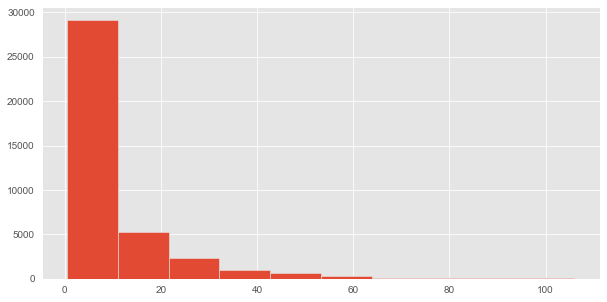

In [70]:
with plt.style.context('ggplot'):
    food_df[food_df[column_name] > 0][column_name].hist(figsize = (10, 5));

We can see that in high majority of cases when `Calcium` is not 0 it is less that 10, while range is from 0 to 106.

<h3>Ply Fat:</h3>

In [71]:
column_name = 'Ply Fat'

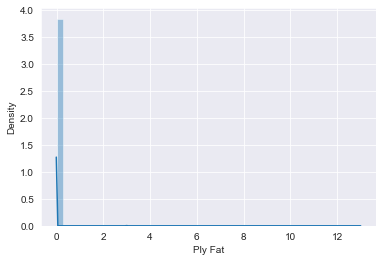

In [72]:
sb.distplot(food_df[column_name]);

It looks even worse than case of `Calcium`, let's look at it more closely.

In [73]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Ply Fatis non-zero in:416/1455111cases (0.02858888428442916%)


We can see that `Ply Fat`  has non-zero value only in 0.02% of our data, which is terribly low. Let's plot only non-zero values.

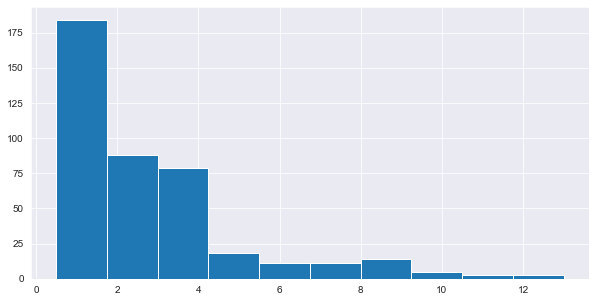

In [74]:
food_df[food_df[column_name] > 0][column_name].hist(figsize=(10, 5));

We can see that most common value for `Ply Fat` when it is not 0, is 1 and it's range varies from 1 to 13.

<h3>Carbs:</h3>

In [75]:
column_name = 'Carbs'

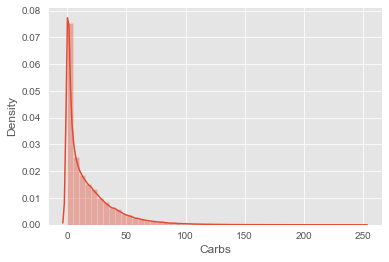

In [76]:
with plt.style.context('ggplot'):
    sb.distplot(food_df[column_name]);

Well, this plot looks different from above cases, let's get into more details.

In [77]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Carbsis non-zero in:1179868/1455111cases (81.08439837235785%)


As we can see we have value of `Carbs` for 4/5 of our food. Let's see more of the plots.  

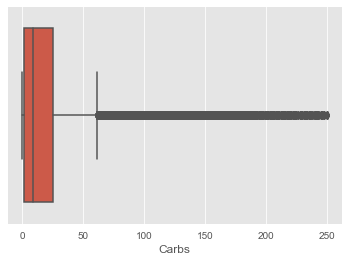

In [78]:
with plt.style.context('ggplot'):
    sb.boxplot(x = column_name, data = food_df);

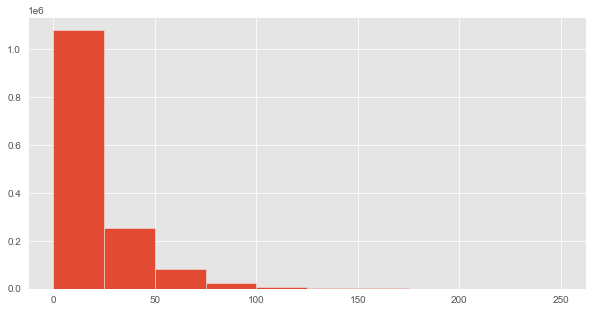

In [79]:
with plt.style.context('ggplot'):
    food_df[column_name].hist(figsize = (10, 5));

In [80]:
food_df[food_df[column_name] <= 25].shape[0] / food_df.shape[0]

0.7515282339285456

We can see that 75% of food have `Carbs` value of less than 25.

<h3>Chol:</h3>

In [81]:
column_name = 'Chol'

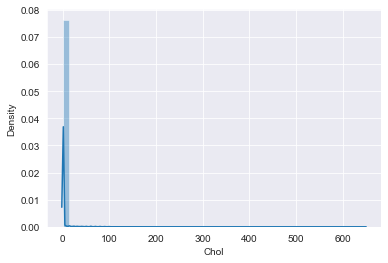

In [82]:
sb.distplot(food_df[column_name]);

It looks like similar case of `Calcium`

In [83]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Cholis non-zero in:20506/1455111cases (1.409239570039674%)


As we can see `Chol` has non-zero value only in 1.4% of our data and that explains our plot's look. Let's plot only non-zero values.

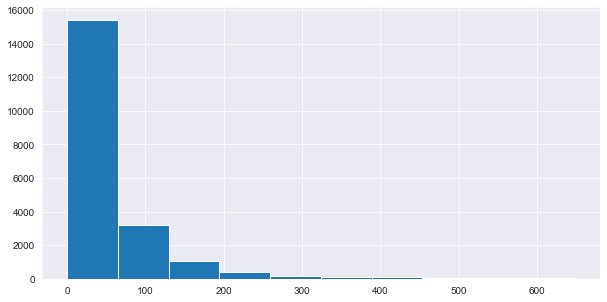

In [84]:
food_df[food_df[column_name] > 0][column_name].hist(figsize = (10, 5));

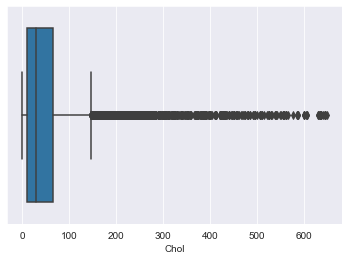

In [85]:
sb.boxplot(x = column_name, data = food_df[food_df[column_name] > 0]);

We can see that in high majority of cases when `Chol` is not 0 it is less that 50 and it varies from 0 to 648.

<h3>Fiber:</h3>

In [86]:
column_name = 'Fiber'

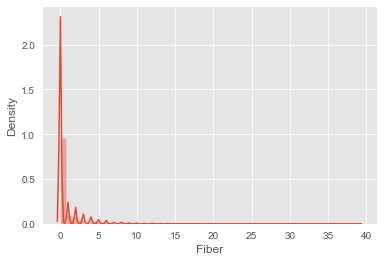

In [87]:
with plt.style.context('ggplot'):
    sb.distplot(food_df[column_name]);

This plot is different from every above plot, let's investigate more.

In [88]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Fiberis non-zero in:370748/1455111cases (25.479018439143132%)


Above plot can be explained by the fact that `Fiber` has non-zero in 1/4 of our data, so it still contains 75% zeroes which is still high number, so let's plot non-zero entries.

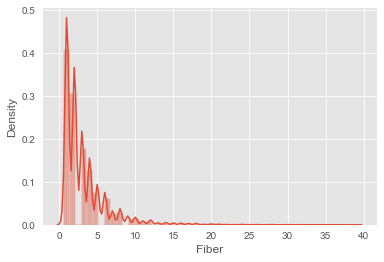

In [89]:
with plt.style.context('ggplot'):
    sb.distplot(food_df[food_df[column_name] > 0][column_name]);

We can see that in high majority of cases when `Fiber` is not 0 it has value from 0 to 5, while it'srange varies from 0 to 39.

<h3>Protein:</h3>

In [90]:
column_name = 'Protein'

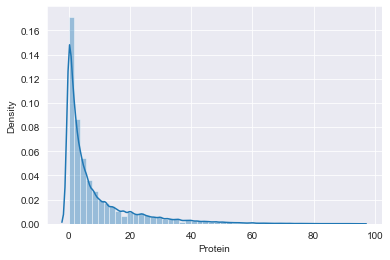

In [91]:
sb.distplot(food_df[column_name]);

It looks like we have similar case of `Carbs`.

In [92]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Proteinis non-zero in:1157045/1455111cases (79.51592696364744%)


Our supposition above was correct, `Protein` is non-zero entered in almost 4/5 cases just like `Carbs`. Let's see more of the plots.

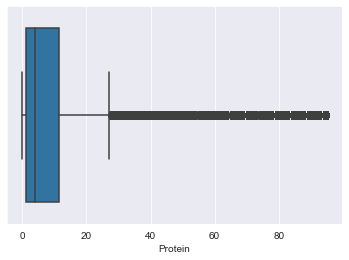

In [93]:
sb.boxplot(x = column_name, data = food_df);

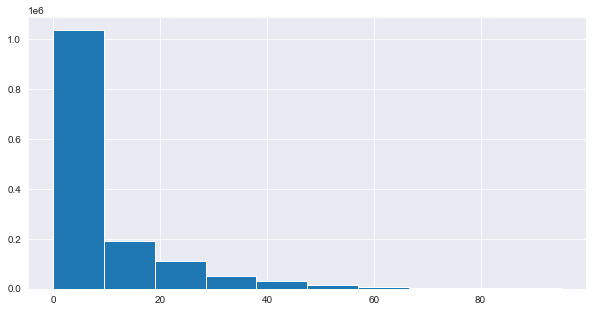

In [94]:
food_df[column_name].hist(figsize = (10, 5));

In [95]:
food_df[food_df[column_name] < 12].shape[0] / food_df.shape[0]

0.7500609919105827

Plots also look like `Carbs` plots but numbers ar changed. So if 75% of food had `Carbs` value of less than 25, in this case 75% of food have `Protein` value of less than 12.

<h3>Calories:</h3>

In [96]:
column_name = 'Calories'

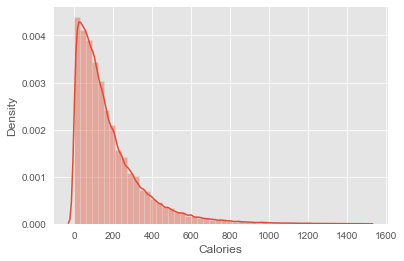

In [97]:
with plt.style.context('ggplot'):
    sb.distplot(food_df[column_name]);

We aleardy knew that `Calories` would have best plot, because it is most entered nutrition for all foods. Let's check percentage of entries.

In [98]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Caloriesis non-zero in:1431129/1455111cases (98.35187831031446%)


As suspected almost every food has `Calories` value, only 1.65% doesn't. Let's see the distributions.

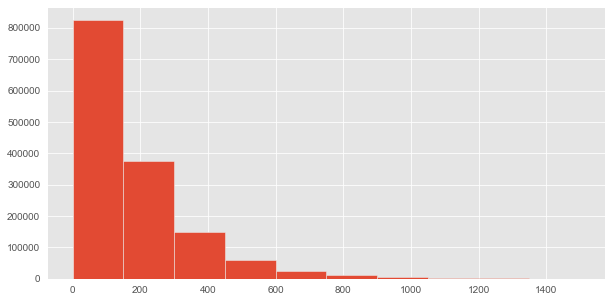

In [99]:
with plt.style.context('ggplot'):
    food_df[column_name].hist(figsize = (10, 5));

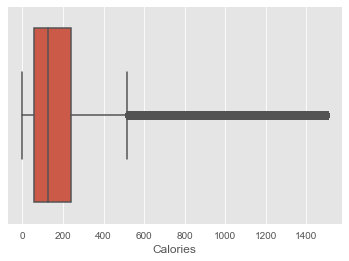

In [100]:
with plt.style.context('ggplot'):
    sb.boxplot(x = column_name, data = food_df);

In [101]:
print('Food percentage under 300 Calories:', food_df[food_df[column_name] <= 300].shape[0] / food_df.shape[0] * 100, '%')

Food percentage under 300 Calories: 83.28697948129043 %


In [102]:
print('Mean:', food_df[column_name].mean())

Mean: 175.90405266963097


We can see that high majority of entered food(83%) has `Calories` value of less than 300, also mean for foods is 176 `Calories`. 

<h3>Trn Fat:</h3>

In [103]:
column_name = 'Trn Fat'

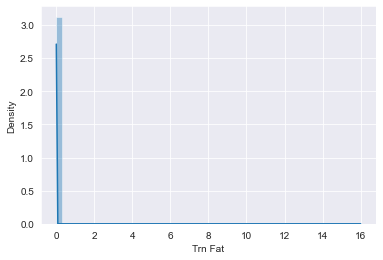

In [104]:
sb.distplot(food_df[column_name]);

This plot looks pretty bad, let's check why is that.

In [105]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Trn Fatis non-zero in:143/1455111cases (0.009827428972772523%)


As we can see `Trn Fat` has non-zero value only in 0.01% of our data and that explains our plot's look. Let's plot only non-zero values.

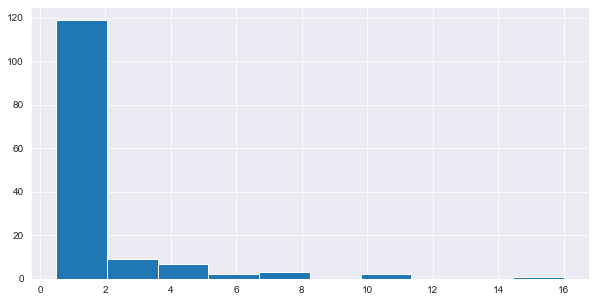

In [106]:
food_df[food_df[column_name] > 0][column_name].hist(figsize = (10, 5));

In [107]:
print('Percentage of Trn Fat with value 1:',
      food_df[food_df[column_name] == 1].shape[0] / food_df[food_df[column_name] > 0].shape[0] * 100,
      '%')

Percentage of Trn Fat with value 1: 60.83916083916085 %


We can see that in majority of cases (61%) when `Trn Fat` is not 0 it is equal to 1.

<h3>Fat:</h3>

In [108]:
column_name = 'Fat'

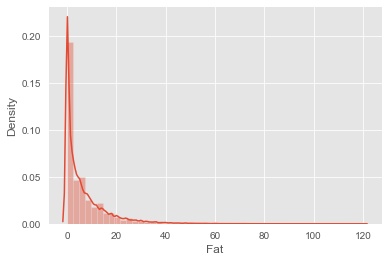

In [109]:
with plt.style.context('ggplot'):
    sb.distplot(food_df[column_name]);

Let's check non-zero count of `Fat`.

In [110]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Fatis non-zero in:1025351/1455111cases (70.46548338923972%)


As we can see `Fat` has non-zero value in 70% of our data and that explains our plot's look. Let's look more into the distributions.

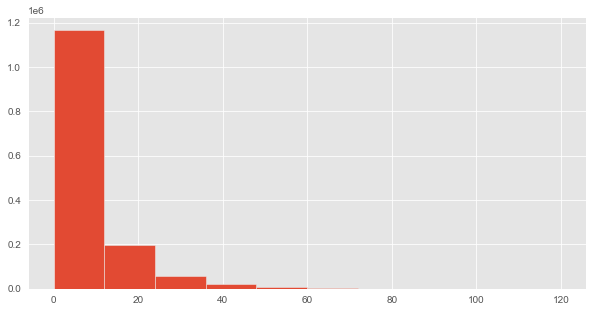

In [111]:
with plt.style.context('ggplot'):
    food_df[column_name].hist(figsize = (10, 5));

In [112]:
print('Food percentage under 12 Fat:', food_df[food_df[column_name] < 12].shape[0] / food_df.shape[0] * 100, '%')

Food percentage under 12 Fat: 80.1791753343903 %


In [113]:
print('Mean:', food_df[column_name].mean())

Mean: 6.724742971989776


We can see that 4/5 of enterd food has `Fat` value of less than 12, also mean for foods is 6.7 `Fat`. 

<h3>Potass.:</h3>

In [114]:
column_name = 'Potass.'

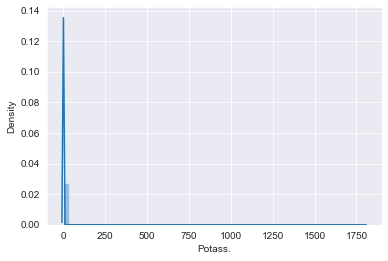

In [115]:
sb.distplot(food_df[column_name]);

This plot looks looks like case of `Calcium`, let's check it out.

In [116]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Potass.is non-zero in:22837/1455111cases (1.569433534623819%)


As we can see `Potas.` has non-zero value only in 1.5% of our data and that explains our plot's look. Let's plot only non-zero values.

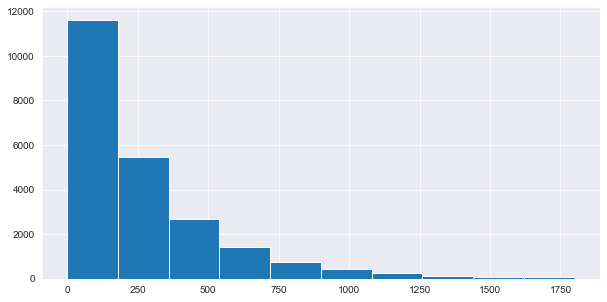

In [117]:
food_df[food_df[column_name] > 0][column_name].hist(figsize = (10, 5));

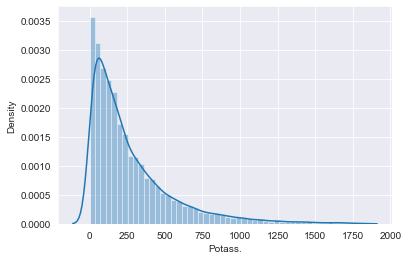

In [118]:
sb.distplot(food_df[food_df[column_name] > 0][column_name]);

In [119]:
print('Mean:', food_df[food_df[column_name] > 0][column_name].mean())

Mean: 269.3119090365051


We can see that most of the food have `Potass.` value less than 500 while it is non-zero with mean of 269.

<h3>Iron:</h3>

In [120]:
column_name = 'Iron'

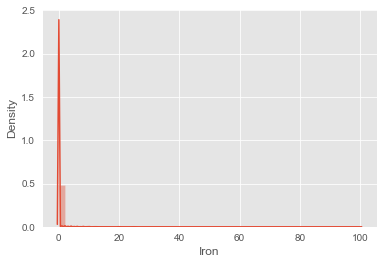

In [121]:
with plt.style.context('ggplot'):
    sb.distplot(food_df[column_name]);

Another one with look of case `Calcium`

In [122]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Ironis non-zero in:52081/1455111cases (3.5791771211955656%)


As we can see `Iron` has non-zero value only in 3.5% of our data and that explains our plot's look. Let's plot only non-zero values.

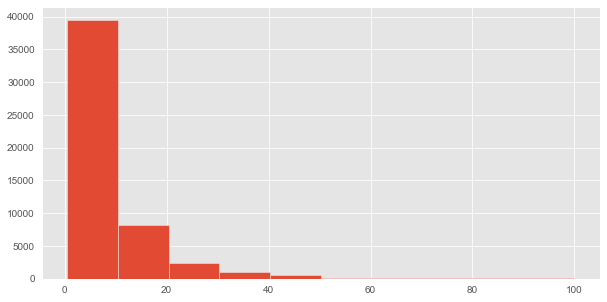

In [123]:
with plt.style.context('ggplot'):
    food_df[food_df[column_name] > 0][column_name].hist(figsize = (10, 5));

We can see that in high majority of cases when `Iron` is not 0 it is less that 10.

<h3>Sat Fat:</h3>

In [124]:
column_name = 'Sat Fat'

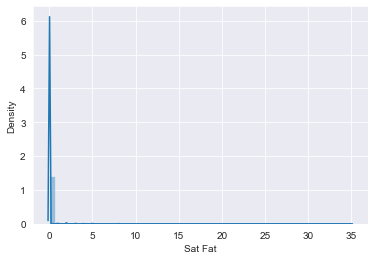

In [125]:
sb.distplot(food_df[column_name]);

Yet another case of case `Calcium`.

In [126]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Sat Fatis non-zero in:28213/1455111cases (1.9388898853764422%)


As we can see `Sat Fat` has non-zero value only in 1.9% of our data and that explains our plot's look. Let's plot only non-zero values.

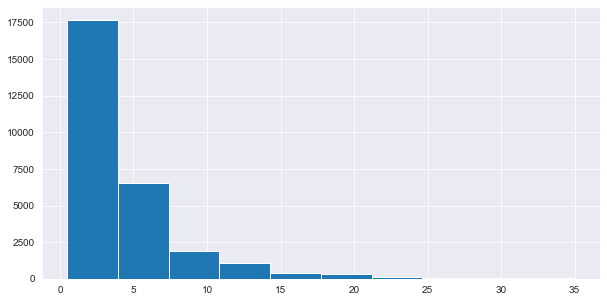

In [127]:
food_df[food_df[column_name] > 0][column_name].hist(figsize = (10, 5));

We can see that in high majority of cases when `Sat Fat` is not 0 it is less that 7.

<h3>Vit A:</h3>

In [128]:
column_name = 'Vit A'

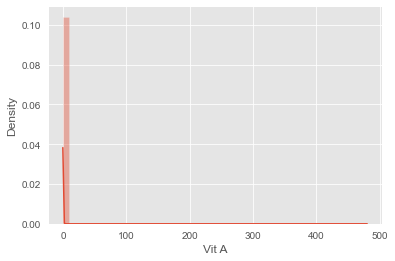

In [129]:
with plt.style.context('ggplot'):
    sb.distplot(food_df[column_name]);

This plot looks like case of `Ply Fat`, let's check the similiarities.

In [130]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Vit Ais non-zero in:1039/1455111cases (0.07140348743154303%)


As we can see `Vit A` has non-zero value only in 0.07% of our data and that explains our plot's look also similarity to case `Ply Fat` which had 0.02% of non-zero data. Let's plot only non-zero values.

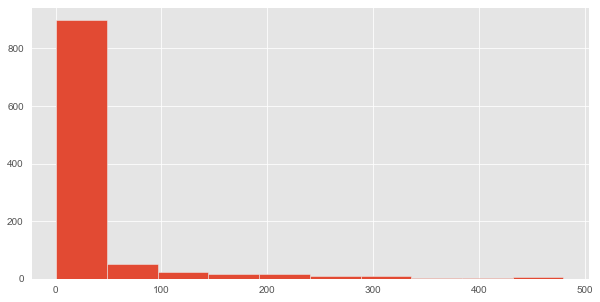

In [131]:
with plt.style.context('ggplot'):
    food_df[food_df[column_name] > 0][column_name].hist(figsize = (10, 5));

We can see that in high majority almost 90% of cases when `Vit A` is not 0 it is in 0-50 range.

<h3>Sodium:</h3>

In [132]:
column_name = 'Sodium'

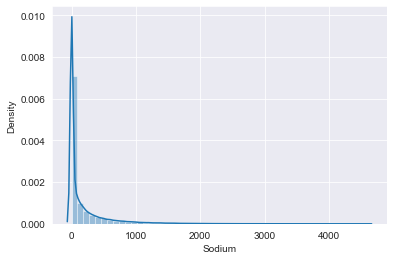

In [133]:
sb.distplot(food_df[column_name]);

Let's check out non-zero percentage of `Sodium`.

In [134]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Sodiumis non-zero in:798209/1455111cases (54.855540230264225%)


As we can see `Sodium` has non-zero value only in 55% of our data, which is not bad. Let's plot both plots: only non-zero and whole.

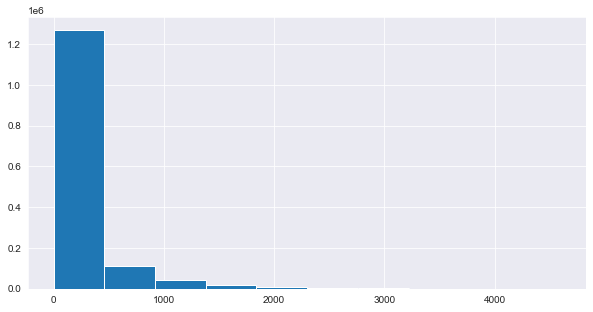

In [135]:
food_df[column_name].hist(figsize = (10, 5));

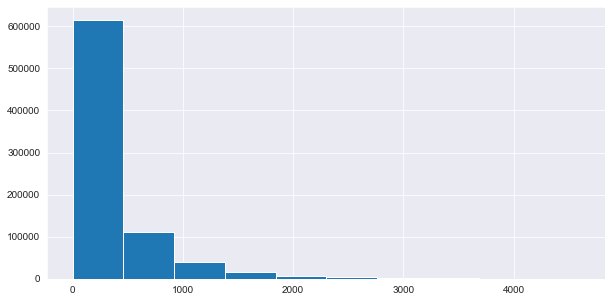

In [136]:
food_df[food_df[column_name] > 0][column_name].hist(figsize = (10, 5));

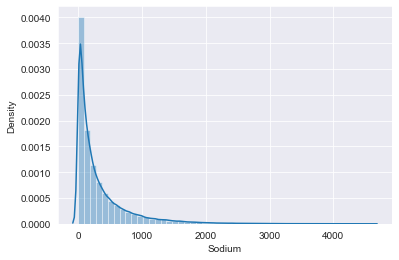

In [137]:
sb.distplot(food_df[food_df[column_name] > 0][column_name]);

Now let's compare means.

In [138]:
print('Only non-zero mean:', food_df[food_df[column_name] > 0][column_name].mean(), '\nActual mean:', food_df[column_name].mean())

Only non-zero mean: 329.4004611002083 
Actual mean: 180.6944024575007


It is clear that most of the `Sodium` is under 500 mark with mean of 329, which drops to 180 when we also count zeroes in.  

<h3>Vit C:</h3>

In [139]:
column_name = 'Vit C'

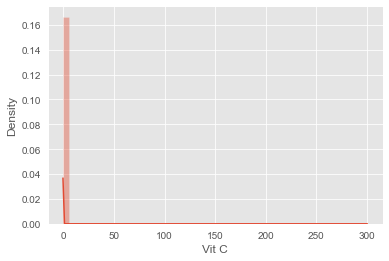

In [140]:
with plt.style.context('ggplot'):
    sb.distplot(food_df[column_name]);

This plot looks almost same as `Ply Fat` case.

In [141]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Vit Cis non-zero in:1832/1455111cases (0.12590104809873612%)


As we can see Calcium has non-zero value only in 0.12% of our data and that explains our plot's look. Let's plot only non-zero values.

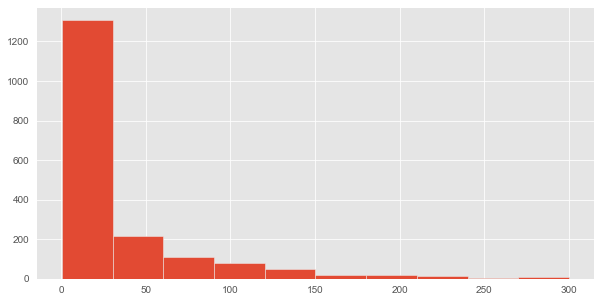

In [142]:
with plt.style.context('ggplot'):
    food_df[food_df[column_name] > 0][column_name].hist(figsize = (10, 5));

We can see that in high majority of cases when `Vit C` is not 0 it is less that 25.

<h3>Sugar:</h3>

In [143]:
column_name = 'Sugar'

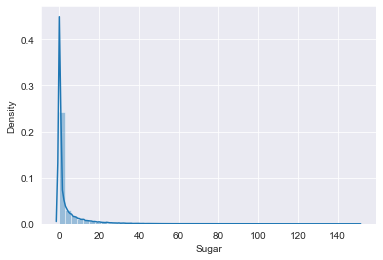

In [144]:
sb.distplot(food_df[column_name]);

This plot looks like a case of `Sodium`.

In [145]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Sugaris non-zero in:591434/1455111cases (40.64528410547374%)


As we can see `Sugar` has non-zero value only in 41% of our data and that explains our plot's look. Let's plot both plots: only non-zero and whole.

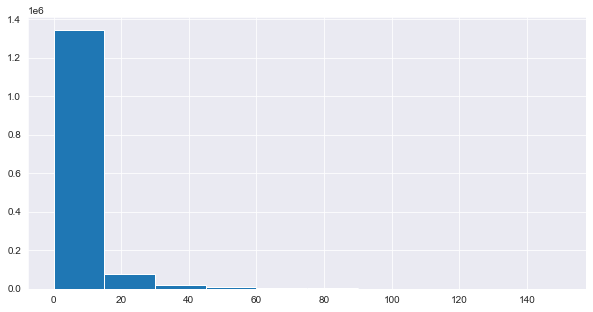

In [146]:
food_df[column_name].hist(figsize = (10, 5));

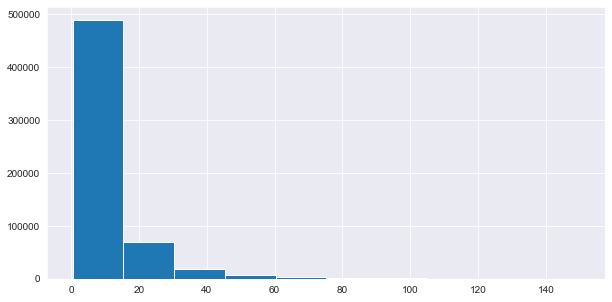

In [147]:
food_df[food_df[column_name] > 0][column_name].hist(figsize = (10, 5));

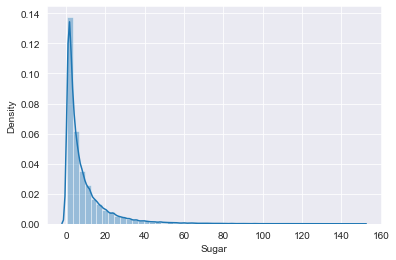

In [148]:
sb.distplot(food_df[food_df[column_name] > 0][column_name]);

Now let's compare means.

In [149]:
print('Only non-zero mean:', food_df[food_df[column_name] > 0][column_name].mean(), '\nActual mean:', food_df[column_name].mean())

Only non-zero mean: 9.194218589794389 
Actual mean: 3.737016267100209


It is clear that most of the `Sugar` is under 15 mark with mean of 9, which drops to 3.7 when we also count zeroes in.  

<h3>Mon Fat:</h3>

In [150]:
column_name = 'Mon Fat'

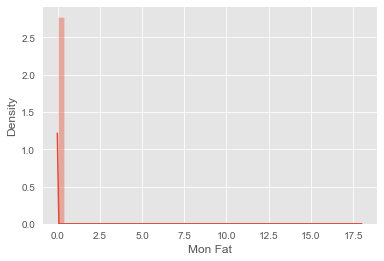

In [151]:
with plt.style.context('ggplot'):
    sb.distplot(food_df[column_name]);

This looks like yet another case of `Ply Fat`, let's check it out.

In [152]:
print(column_name, 'is non-zero in:', food_df[food_df[column_name] > 0].shape[0], '/', food_df.shape[0], 'cases (',
      food_df[food_df[column_name] > 0].shape[0] / food_df.shape[0] * 100, '%)', sep = '')

Mon Fatis non-zero in:209/1455111cases (0.01436316542174446%)


As we can see Calcium has non-zero value only in 0.014% of our data and that explains our plot's look. Let's plot only non-zero values.

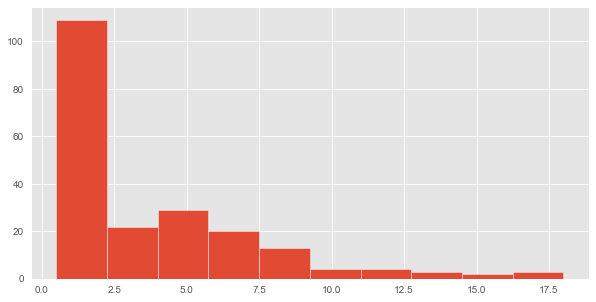

In [153]:
with plt.style.context('ggplot'):
    food_df[food_df[column_name] > 0][column_name].hist(figsize = (10, 5));

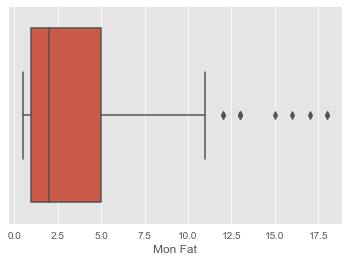

In [154]:
with plt.style.context('ggplot'):
    sb.boxplot(x = column_name, data = food_df[food_df[column_name] > 0]);

We can see that in high majority of cases when `Mon Fat` is not 0 it is less or equal than 5. Also it's mean is almost 2.5.

After all this now let's build correlations matrix to see correlations between nutritions.

<h3>Correlations:</h3>

We will use the heatmap to visualize the correlations between the variables.

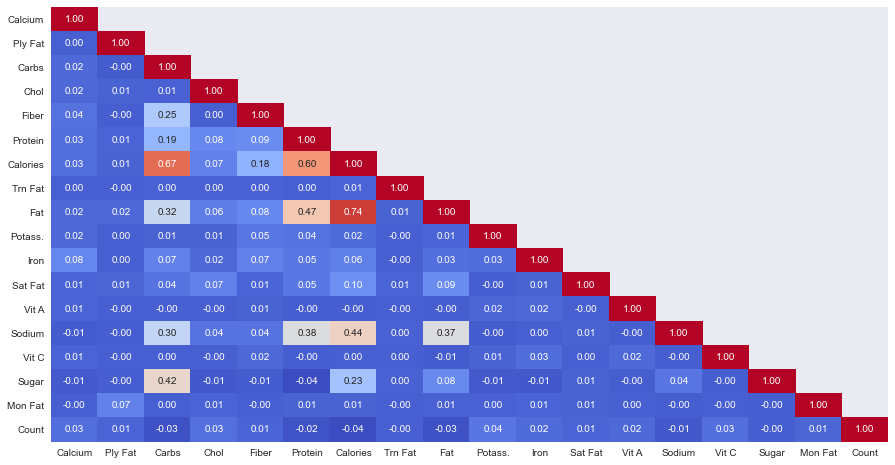

In [155]:
matrix = food_df.corr()
f, ax = plt.subplots(figsize = (15, 8))
with sb.axes_style('white'):
    sb.heatmap(matrix, mask = np.triu(matrix, 1), annot = True, fmt = '0.2f', vmax = 0.8, cbar = False, cmap = 'coolwarm');

Looking at the heatmap we can notice that `Calories` is in correlation with `Fat`,`Carbs`,`Protein`, `Sodium`. Also, `Sugar` and `Carbs` are correlated with each other too. These correlations are probably incurred by the fact that `Calories` and nutrients that are correlated to it are probably most "popular" ones, so that in majority of cases these nutritions are entered and others are mostly zeroes. But high correlations like `Calories` and `Fat` or `Calories` and `Carbs`, will not be explained only by that, they are probably truly correlated.

<h1><span style="color:blue">Feature Engineering</span></h1>

<h3>Choosing clustering variables:</h3>

As we have seen above, some nutritions are entered very rarely. We can again look at nutritions sorted percenteges.

In [156]:
nutrition_percentages = dict()

for column in column_names:
    nutrition_percentages[column] = food_df[food_df[column] > 0].shape[0] / food_df.shape[0] * 100

sorted_nutritions = sorted(nutrition_percentages, key = nutrition_percentages.get, reverse = True)

for nutrition in sorted_nutritions:
    print(nutrition, (20 - len(nutrition)) * '-', str(round(nutrition_percentages[nutrition], 2)),
          ' %' if nutrition_percentages[nutrition] < 10 else '%')

Calories ------------ 98.35 %
Carbs --------------- 81.08 %
Protein ------------- 79.52 %
Fat ----------------- 70.47 %
Sodium -------------- 54.86 %
Sugar --------------- 40.65 %
Fiber --------------- 25.48 %
Iron ---------------- 3.58  %
Calcium ------------- 2.68  %
Sat Fat ------------- 1.94  %
Potass. ------------- 1.57  %
Chol ---------------- 1.41  %
Vit C --------------- 0.13  %
Vit A --------------- 0.07  %
Ply Fat ------------- 0.03  %
Mon Fat ------------- 0.01  %
Trn Fat ------------- 0.01  %


As we can see, there are 10 nutritions that are present in less then 4% of food entries, others are more than 25%. Since we are going to cluster food, these nutritions will pollute clusters, hence this information is very poor. So, we should not include them in clustering variables, that will also reduce dimensionality of clustering data.

In [157]:
clustering_variables = ['Calories', 'Carbs', 'Protein', 'Fat', 'Sodium', 'Sugar', 'Fiber'] 

<h3>Creating new features:</h3>

<h4>Food Heaviness</h4>

Another description that can be applied to food is how heavy (მსუყე/მძიმე) it is. That can be determined by three nutritions: `Calories`, `Fat`, `Sugar`. So we can take their sum as measure of heaviness. But there is one problem their ranges and variances differ highly. That is a problem because for example: food with (0 `Calories`, 0 `Fat`, and 20 `Sugar`) will be way more heavy than food with (100 `Calories`, 0 `Fat` and 0 `Sugar`). To solve that problem, we have to normalize each column and then take their sum. So range of `Food Heaviness` will be [0,3].

In [158]:
scaler = MinMaxScaler()
food_df['Food Heaviness'] = scaler.fit_transform(food_df[['Calories','Fat','Sugar']]).sum(axis = 1)
food_df.head()

Name  Calcium  Ply Fat  Carbs  \
0  Coffee - Brewed from grounds, 2 cup (8 fl oz)      1.0      0.0    0.0   
1  Coffee - Brewed from grounds, 1 cup (8 fl oz)      0.0      0.0    0.0   
2  Coffee - Brewed from grounds, 3 cup (8 fl oz)      1.0      0.0    0.0   
3                           Spinach - Raw, 1 cup      3.0      0.0    1.0   
4              Eggs - Fried (whole egg), 1 large      3.0      0.0    0.0   

    Chol  Fiber  Protein  Calories  Trn Fat  Fat  Potass.  Iron  Sat Fat  \
0    0.0    0.0      1.0       5.0      0.0  0.0    232.0   0.0      0.0   
1    0.0    0.0      0.0       2.0      0.0  0.0    116.0   0.0      0.0   
2    0.0    0.0      1.0       7.0      0.0  0.0    348.0   0.0      0.0   
3    0.0    1.0      1.0       7.0      0.0  0.0    167.0   5.0      0.0   
4  210.0    0.0      6.0      92.0      0.0  7.0     68.0   5.0      2.0   

   Vit A  Sodium  Vit C  Sugar  Mon Fat  Count  Food Heaviness  
0    0.0     9.0    0.0    0.0      0.0  21011        0.003333  
1    0.0     5.0    0.0    0.0      0.0  19888        0.001333  
2    0.0    14.0    0.0    0.0      0.0   7206        0.004667  
3   56.0    24.0   14.0    0.0      0.0   7251        0.004667  
4    7.0    94.0    0.0    0.0      0.0   4858        0.119667

Now let's analyse our new feature.

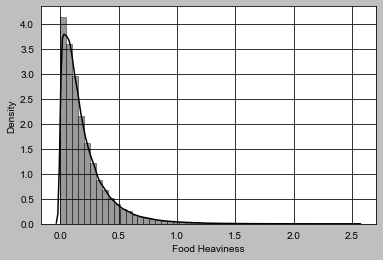

In [159]:
with plt.style.context('grayscale'):
    sb.distplot(food_df['Food Heaviness']);

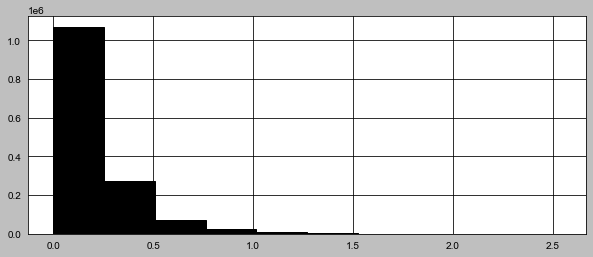

In [160]:
with plt.style.context('grayscale'):
    food_df['Food Heaviness'].hist(figsize = (10, 4));

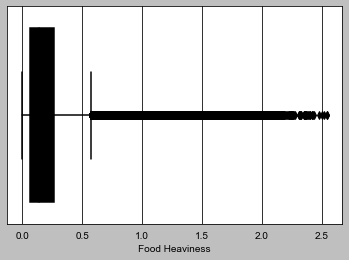

In [161]:
with plt.style.context('grayscale'):
    sb.boxplot(x = 'Food Heaviness', data = food_df);

From above plots we can infer that customers are mostly eating light foods and that was probably expected from the nature of process with which was our data gathered. Also food heaviness is mostly between 0.05 and 0.3, while it's range is [0, 2.54].

We will use this feature as our another clustering variable.

In [162]:
clustering_variables.append('Food Heaviness')

<h4>Calories Category</h4>

Since `Calories` is the most important food-defining feature for several reasons:
- People who are trying to control their food intake usually pay most attention to calories;
- In our data Calories are entered most frequently;
- Lastly, it is most correlated with other nutritions so it expresses their values too even if they are absent.

We shall add `Calories Category` as a new feature.

Also, Foods shall be categorized in 4 categories - low, low-average, high-average and high, denoted by numbers 0 to 3 respectively.

In [163]:
def get_calorie_category(x):
    if x <= 60:
        return 0
    if x <= 176:
        return 1
    if x <= 300: 
        return 2
    return 3

In [164]:
food_df['Calorie Category'] = food_df['Calories'].apply(get_calorie_category)
food_df.head()

Name  Calcium  Ply Fat  Carbs  \
0  Coffee - Brewed from grounds, 2 cup (8 fl oz)      1.0      0.0    0.0   
1  Coffee - Brewed from grounds, 1 cup (8 fl oz)      0.0      0.0    0.0   
2  Coffee - Brewed from grounds, 3 cup (8 fl oz)      1.0      0.0    0.0   
3                           Spinach - Raw, 1 cup      3.0      0.0    1.0   
4              Eggs - Fried (whole egg), 1 large      3.0      0.0    0.0   

    Chol  Fiber  Protein  Calories  Trn Fat  Fat  ...  Iron  Sat Fat  Vit A  \
0    0.0    0.0      1.0       5.0      0.0  0.0  ...   0.0      0.0    0.0   
1    0.0    0.0      0.0       2.0      0.0  0.0  ...   0.0      0.0    0.0   
2    0.0    0.0      1.0       7.0      0.0  0.0  ...   0.0      0.0    0.0   
3    0.0    1.0      1.0       7.0      0.0  0.0  ...   5.0      0.0   56.0   
4  210.0    0.0      6.0      92.0      0.0  7.0  ...   5.0      2.0    7.0   

   Sodium  Vit C  Sugar  Mon Fat  Count  Food Heaviness  Calorie Category  
0     9.0    0.0    0.0      0.0  21011        0.003333                 0  
1     5.0    0.0    0.0      0.0  19888        0.001333                 0  
2    14.0    0.0    0.0      0.0   7206        0.004667                 0  
3    24.0   14.0    0.0      0.0   7251        0.004667                 0  
4    94.0    0.0    0.0      0.0   4858        0.119667                 1  

[5 rows x 21 columns]

Now let's get to analysing our new feature

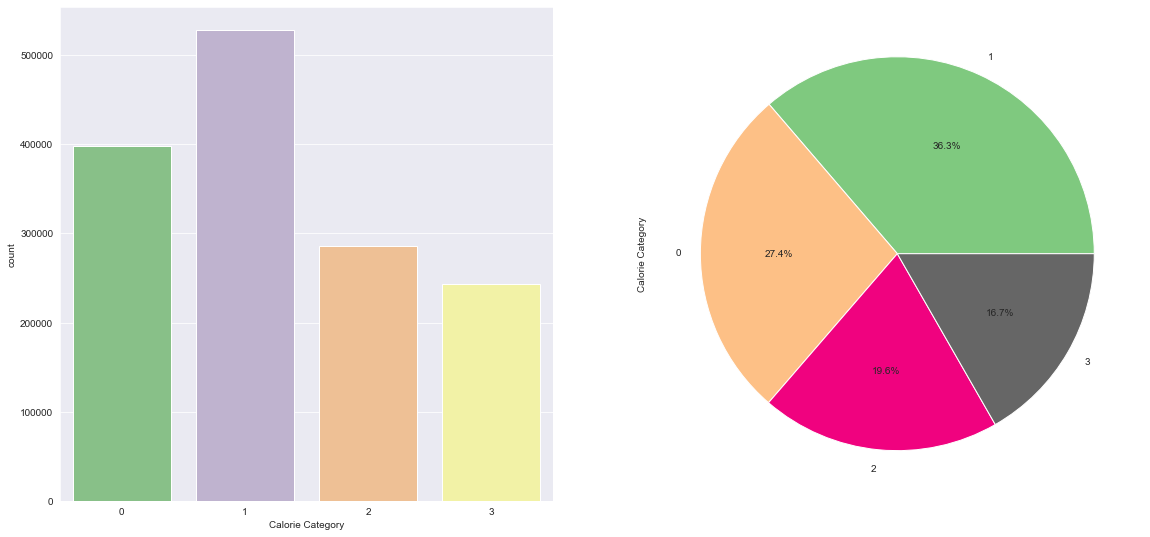

In [165]:
plt.figure(figsize = (30, 20))
plt.subplot(235)
sb.countplot(food_df['Calorie Category'], palette = 'Accent')
plt.subplot(236)
food_df['Calorie Category'].value_counts().plot.pie(cmap = 'Accent', autopct = '%1.1f%%');

Now, let's try multivariate analysis with `Calorie Category`.

<h5>Calorie Category and Carbs</h5>

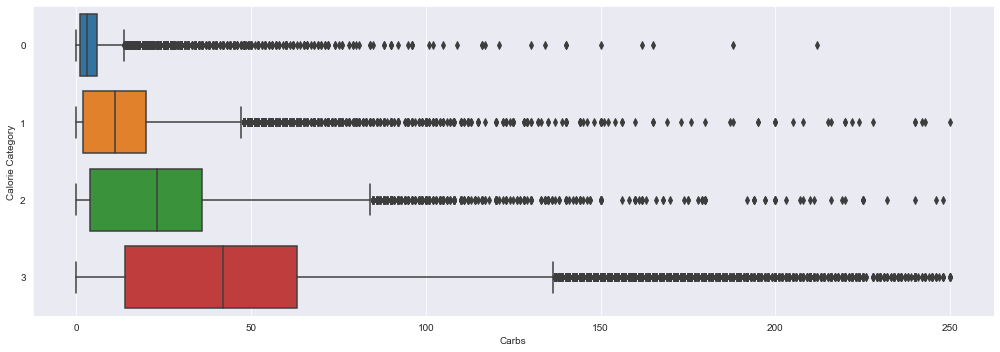

In [166]:
plt.figure(figsize = (14, 5))
ax = sb.boxplot(y = 'Calorie Category', x = 'Carbs', data = food_df, orient = 'h');
fig = plt.gcf()
plt.tight_layout()

Correlation between `Calories` and `Carbs` is pretty clear from this plot. Let's look at means.

In [167]:
food_df.groupby(['Calorie Category'])['Carbs'].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Calorie Category         0          1          2          3
mean              3.921183  12.329598  23.052941  43.737891

<h5>Calorie Category and Fat</h5>

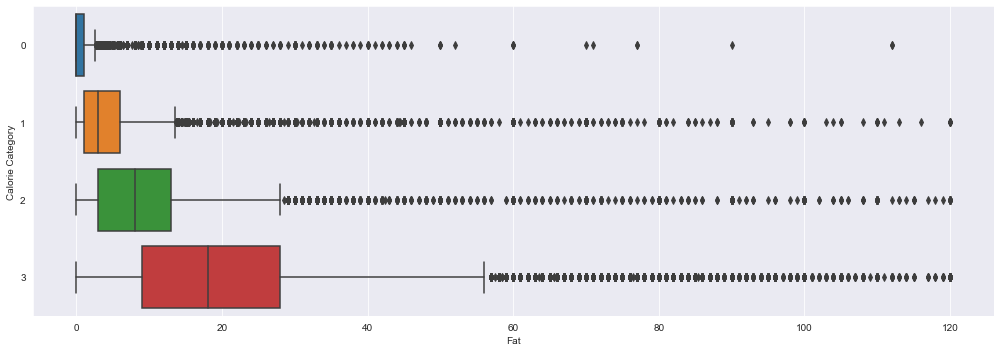

In [168]:
plt.figure(figsize = (14, 5))
ax = sb.boxplot(y = 'Calorie Category', x = 'Fat', data = food_df, orient = 'h');
fig = plt.gcf()
plt.tight_layout()

Correlation between `Calories` and `Fat` is pretty clear from this plot. Let's look at means.

In [169]:
food_df.groupby(['Calorie Category'])['Fat'].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Calorie Category         0         1         2          3
mean              0.917291  4.037928  8.660002  19.794885

<h5>Calorie Category and Protein</h5>

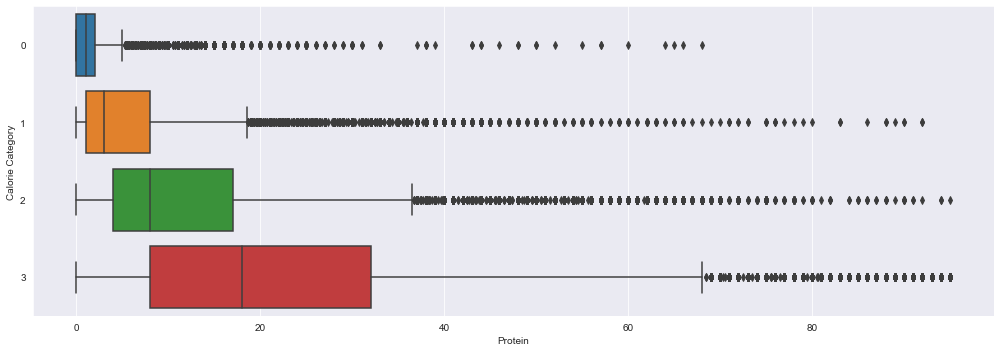

In [170]:
plt.figure(figsize = (14, 5))
ax = sb.boxplot(y = 'Calorie Category', x = 'Protein', data = food_df, orient = 'h');
fig = plt.gcf()
plt.tight_layout()

Correlation between `Calories` and `Protein` is pretty clear from this plot. Let's look at means.

In [171]:
food_df.groupby(['Calorie Category'])['Protein'].agg([np.mean]).sort_values(by='mean', ascending=True).T

Calorie Category         0         1          2          3
mean              1.490627  6.121392  12.141489  22.298559

These plots are pretty much more detailed visual representation of what correlations table said. We can infer that categories of calories also apply to these 3 nutritions as well. Because, for example high calories food with high probability has high protein too. 

We will use this feature as our another clustering variable.

In [172]:
clustering_variables.append('Calorie Category')

<h1><span style="color:blue">Data Preperation for Clustering</span></h1>

<h3>Creating clustering dataframe:</h3>

Let's create new dataframe that consists of only clustering variables.

In [173]:
clustering_df = food_df[clustering_variables]
clustering_df.head()

Calories  Carbs  Protein  Fat  Sodium  Sugar  Fiber  Food Heaviness  \
0       5.0    0.0      1.0  0.0     9.0    0.0    0.0        0.003333   
1       2.0    0.0      0.0  0.0     5.0    0.0    0.0        0.001333   
2       7.0    0.0      1.0  0.0    14.0    0.0    0.0        0.004667   
3       7.0    1.0      1.0  0.0    24.0    0.0    1.0        0.004667   
4      92.0    0.0      6.0  7.0    94.0    0.0    0.0        0.119667   

   Calorie Category  
0                 0  
1                 0  
2                 0  
3                 0  
4                 1

<h3>Reducing skewness:</h3>

1.  For left  skewness, we take squares, cubes or higher powers;
2.  For right skewness, we take roots, logarithms or reciprocals (roots are weakest). 

Skewness formula:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/30324ac725e96b88638a0fc86f201b174082cbc7)

<h3> Helper functions:</h3>

In [174]:
def reduce_skewness(col_name, reducer):
    clustering_df[col_name] = reducer(clustering_df[col_name])

def draw_probability_density_plots_before_and_after_reducing_skewness(col_name, reducer):
    plt.figure(1, figsize = (16, 5))

    plt.subplot(121)
    plt.title('Old Skewness: ' + str(clustering_df[col_name].skew()))
    sb.distplot(clustering_df[col_name], fit = stats.norm);

    reduce_skewness(col_name, reducer)

    plt.subplot(122)
    plt.title('New Skewness: ' + str(clustering_df[col_name].skew()))
    sb.distplot(clustering_df[col_name], fit = stats.norm);

<h3>Reducing skewness for every feature:</h3>

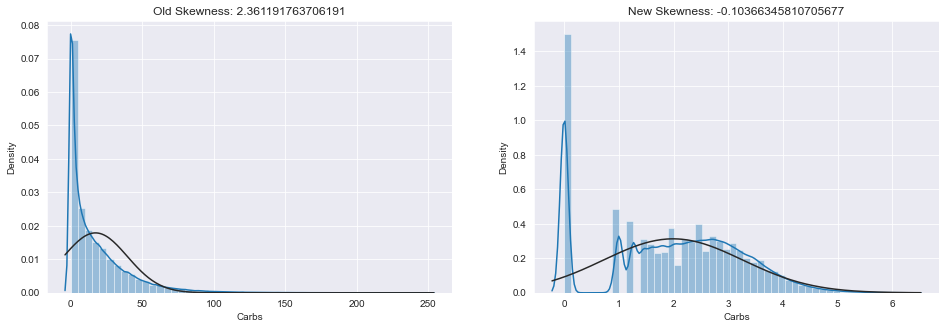

In [175]:
draw_probability_density_plots_before_and_after_reducing_skewness('Carbs', np.cbrt)

# cbrt  - -0.10
# sqrt  -  0.58
# log1p - -0.18

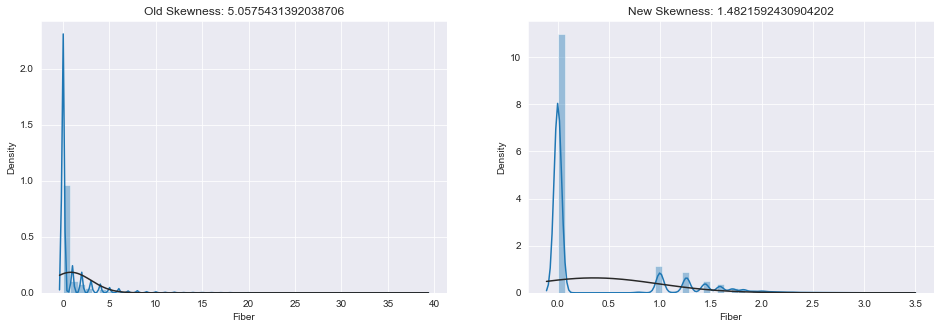

In [176]:
draw_probability_density_plots_before_and_after_reducing_skewness('Fiber', np.cbrt)

# cbrt  - 1.48
# sqrt  - 1.97
# log1p - 1.88

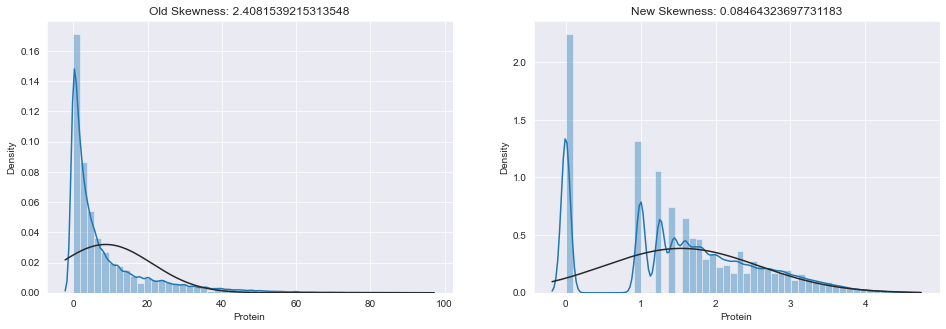

In [177]:
draw_probability_density_plots_before_and_after_reducing_skewness('Protein', np.cbrt)

# cbrt  - 0.08
# sqrt  - 0.84
# log1p - 0.22

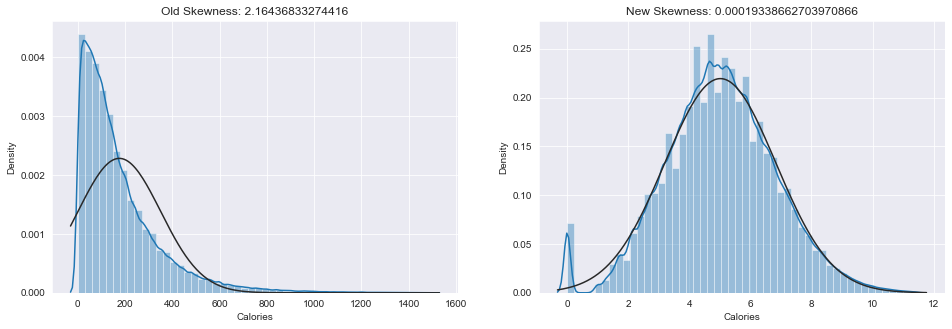

In [178]:
draw_probability_density_plots_before_and_after_reducing_skewness('Calories', np.cbrt)

# cbrt  -  0.0001
# sqrt  -  0.64
# log1p - -1.19

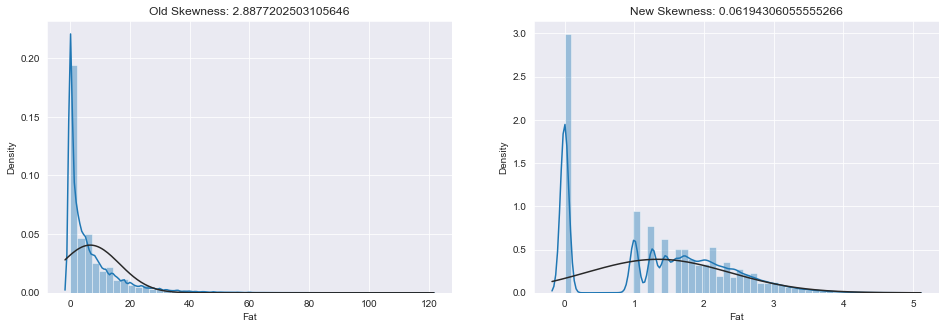

In [179]:
draw_probability_density_plots_before_and_after_reducing_skewness('Fat', np.cbrt)

# cbrt  - 0.06
# sqrt  - 0.76
# log1p - 0.23

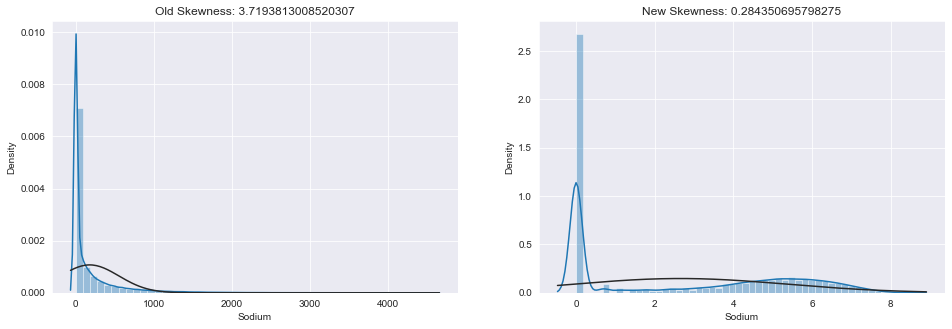

In [180]:
draw_probability_density_plots_before_and_after_reducing_skewness('Sodium', np.log1p)

# cbrt  - 0.79
# sqrt  - 1.45
# log1p - 0.28

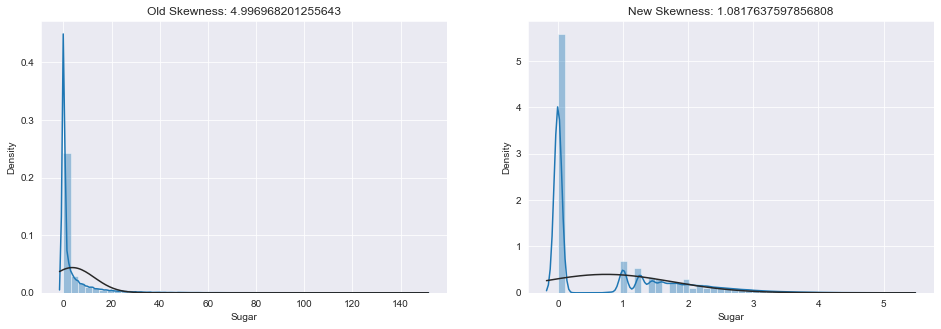

In [181]:
draw_probability_density_plots_before_and_after_reducing_skewness('Sugar', np.cbrt)

# cbrt  - 1.08
# sqrt  - 1.81
# log1p - 1.24

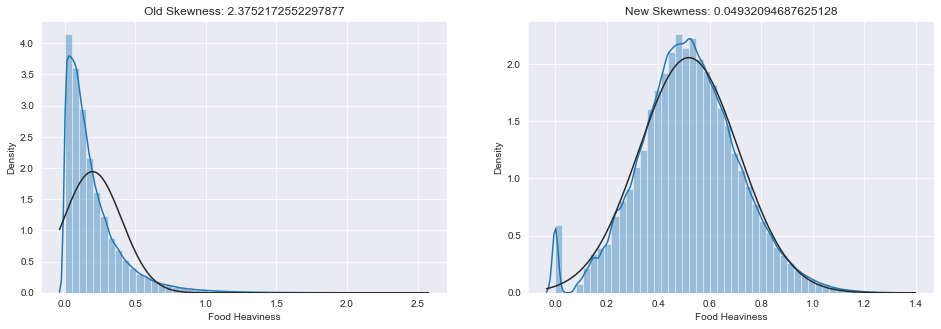

In [182]:
draw_probability_density_plots_before_and_after_reducing_skewness('Food Heaviness', np.cbrt)

# cbrt  - 0.04
# sqrt  - 0.71
# log1p - 1.59

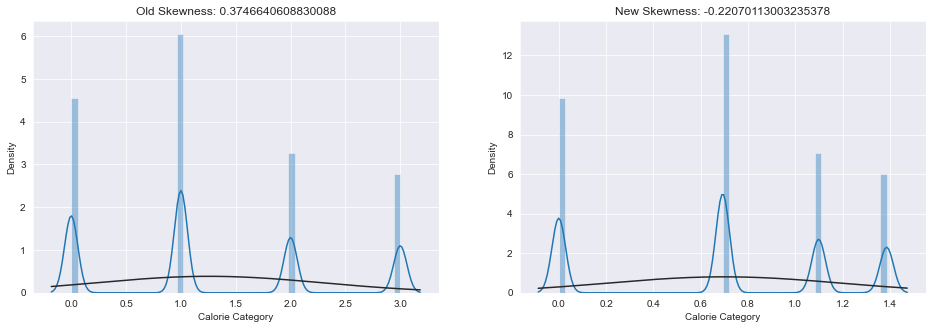

In [183]:
draw_probability_density_plots_before_and_after_reducing_skewness('Calorie Category', np.log1p)

# cbrt  - -0.73
# sqrt  - -0.45
# log1p - -0.22

<h3>Normalization:</h3>

We have only numerical variables in our datasets, but they have different ranges. So, we have to normalize them. Normalization is the second essential preprocessing step of clustering algorithms, since they are based on minimizing the Euclidean distance between the data set points and cluster centroids, which are sensitive to differences in magnitude or scale of the features.

In [184]:
scaler = MinMaxScaler()
clustering_df[clustering_variables] = scaler.fit_transform(clustering_df[clustering_variables])

In [185]:
clustering_df.head()

Calories    Carbs   Protein       Fat    Sodium  Sugar    Fiber  \
0  0.149380  0.00000  0.219159  0.000000  0.273011    0.0  0.00000   
1  0.110064  0.00000  0.000000  0.000000  0.212444    0.0  0.00000   
2  0.167110  0.00000  0.219159  0.000000  0.321086    0.0  0.00000   
3  0.167110  0.15874  0.219159  0.000000  0.381653    0.0  0.29488   
4  0.394365  0.00000  0.398238  0.387828  0.539941    0.0  0.00000   

   Food Heaviness  Calorie Category  
0        0.109483               0.0  
1        0.080668               0.0  
2        0.122478               0.0  
3        0.122478               0.0  
4        0.361171               0.5

<h1><span style="color:blue">Clustering With K-Means</span></h1>

In [186]:
#clustering_df.to_csv('clustering_df.csv')

In [187]:
clustering_df = pd.read_csv('clustering_df.csv')
clustering_df.drop(clustering_df.columns[0], inplace = True, axis = 1)

In [188]:
clustering_df.head()

Calories    Carbs   Protein       Fat    Sodium  Sugar    Fiber  \
0  0.149380  0.00000  0.219159  0.000000  0.273011    0.0  0.00000   
1  0.110064  0.00000  0.000000  0.000000  0.212444    0.0  0.00000   
2  0.167110  0.00000  0.219159  0.000000  0.321086    0.0  0.00000   
3  0.167110  0.15874  0.219159  0.000000  0.381653    0.0  0.29488   
4  0.394365  0.00000  0.398238  0.387828  0.539941    0.0  0.00000   

   Food Heaviness  Calorie Category  
0        0.109483               0.0  
1        0.080668               0.0  
2        0.122478               0.0  
3        0.122478               0.0  
4        0.361171               0.5

Let's run K-Means 20 times with 1-20 clusters and check total costs. This will help us determine best number of clusters.

In [189]:
costs = []

for k in range(1, 21):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(clustering_df)
    costs.append(kmeans.inertia_)

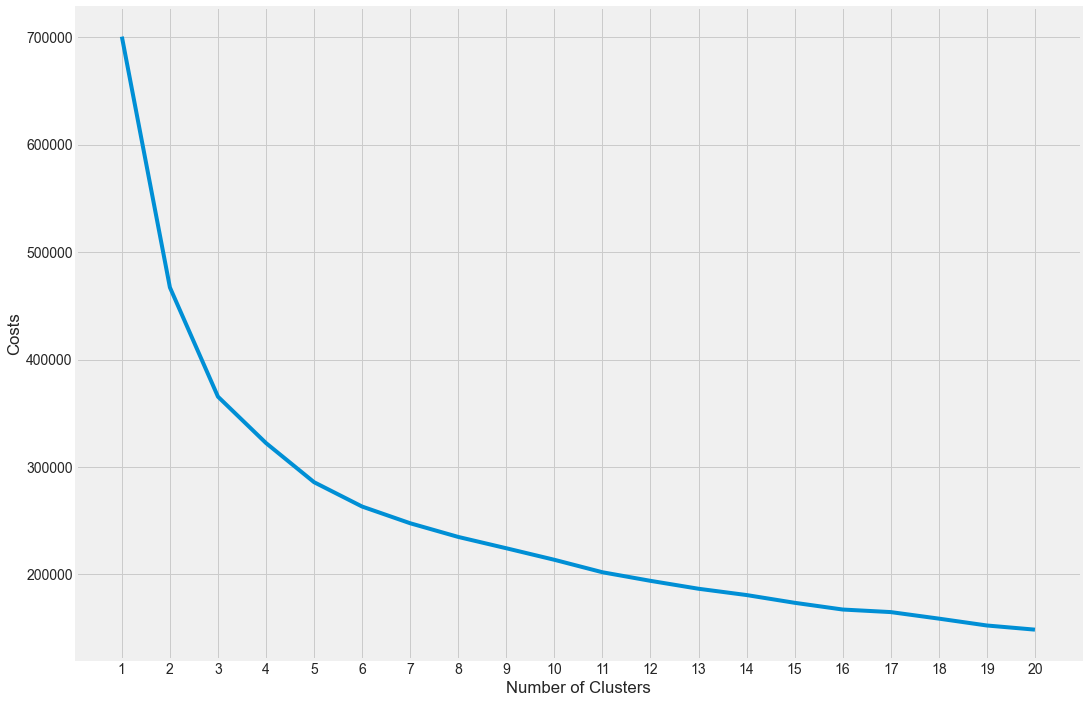

Cluster Number: 1  | Cost: 700555 | Cost Change: 700555
Cluster Number: 2  | Cost: 467101 | Cost Change: -233453
Cluster Number: 3  | Cost: 365414 | Cost Change: -101687
Cluster Number: 4  | Cost: 322228 | Cost Change: -43185
Cluster Number: 5  | Cost: 285795 | Cost Change: -36432
Cluster Number: 6  | Cost: 263126 | Cost Change: -22669
Cluster Number: 7  | Cost: 247579 | Cost Change: -15546
Cluster Number: 8  | Cost: 234844 | Cost Change: -12734
Cluster Number: 9  | Cost: 224310 | Cost Change: -10534
Cluster Number: 10 | Cost: 213575 | Cost Change: -10735
Cluster Number: 11 | Cost: 201978 | Cost Change: -11596
Cluster Number: 12 | Cost: 193981 | Cost Change: -7997
Cluster Number: 13 | Cost: 186609 | Cost Change: -7371
Cluster Number: 14 | Cost: 180748 | Cost Change: -5860
Cluster Number: 15 | Cost: 173538 | Cost Change: -7210
Cluster Number: 16 | Cost: 167274 | Cost Change: -6263
Cluster Number: 17 | Cost: 164890 | Cost Change: -2384
Cluster Number: 18 | Cost: 158810 | Cost Change: -60

In [190]:
plt.figure(figsize = (18, 12))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 21), costs)
plt.xticks(range(1, 21))
plt.xlabel("Number of Clusters")
plt.ylabel("Costs")
plt.show()

previous_cost = 0
for i in range(len(costs)):
    print('Cluster Number:', i + 1, ' | Cost:' if i < 9 else '| Cost:', int(costs[i]), '| Cost Change:', int(costs[i] - previous_cost))
    previous_cost = costs[i]

In [191]:
kmeans_12 = KMeans(n_clusters = 12)
kmeans_12.fit(clustering_df)

KMeans(n_clusters=12)

In [192]:
#food_df['Cluster'] = kmeans_12.labels_

In [193]:
#food_df.to_csv('clustered_food_df.csv')

In [194]:
clustered_food_df = pd.read_csv('clustered_food_df.csv')
clustered_food_df.drop(clustered_food_df.columns[0], inplace = True, axis = 1)
clustered_food_df.head()

Name  Calcium  Ply Fat  Carbs  \
0  Coffee - Brewed from grounds, 2 cup (8 fl oz)      1.0      0.0    0.0   
1  Coffee - Brewed from grounds, 1 cup (8 fl oz)      0.0      0.0    0.0   
2  Coffee - Brewed from grounds, 3 cup (8 fl oz)      1.0      0.0    0.0   
3                           Spinach - Raw, 1 cup      3.0      0.0    1.0   
4              Eggs - Fried (whole egg), 1 large      3.0      0.0    0.0   

    Chol  Fiber  Protein  Calories  Trn Fat  Fat  ...  Sat Fat  Vit A  Sodium  \
0    0.0    0.0      1.0       5.0      0.0  0.0  ...      0.0    0.0     9.0   
1    0.0    0.0      0.0       2.0      0.0  0.0  ...      0.0    0.0     5.0   
2    0.0    0.0      1.0       7.0      0.0  0.0  ...      0.0    0.0    14.0   
3    0.0    1.0      1.0       7.0      0.0  0.0  ...      0.0   56.0    24.0   
4  210.0    0.0      6.0      92.0      0.0  7.0  ...      2.0    7.0    94.0   

   Vit C  Sugar  Mon Fat  Count  Food Heaviness  Calorie Category  Cluster  
0    0.0    0.0      0.0  21011        0.003333                 0        6  
1    0.0    0.0      0.0  19888        0.001333                 0        6  
2    0.0    0.0      0.0   7206        0.004667                 0        6  
3   14.0    0.0      0.0   7251        0.004667                 0        9  
4    0.0    0.0      0.0   4858        0.119667                 1        5  

[5 rows x 22 columns]

<h2>Using PCA for Plotting Clusters</h2>

In [195]:
pca3D = PCA(n_components = 3)
pca3D.fit(clustering_df)
data_3D = pca3D.transform(clustering_df)

pca2D = PCA(n_components = 2)
pca2D.fit(clustering_df)
data_2D = pca2D.transform(clustering_df)

In [196]:
sum(pca3D.explained_variance_ratio_)

0.7873067407004964

In [197]:
sum(pca2D.explained_variance_ratio_)

0.6801654384539727

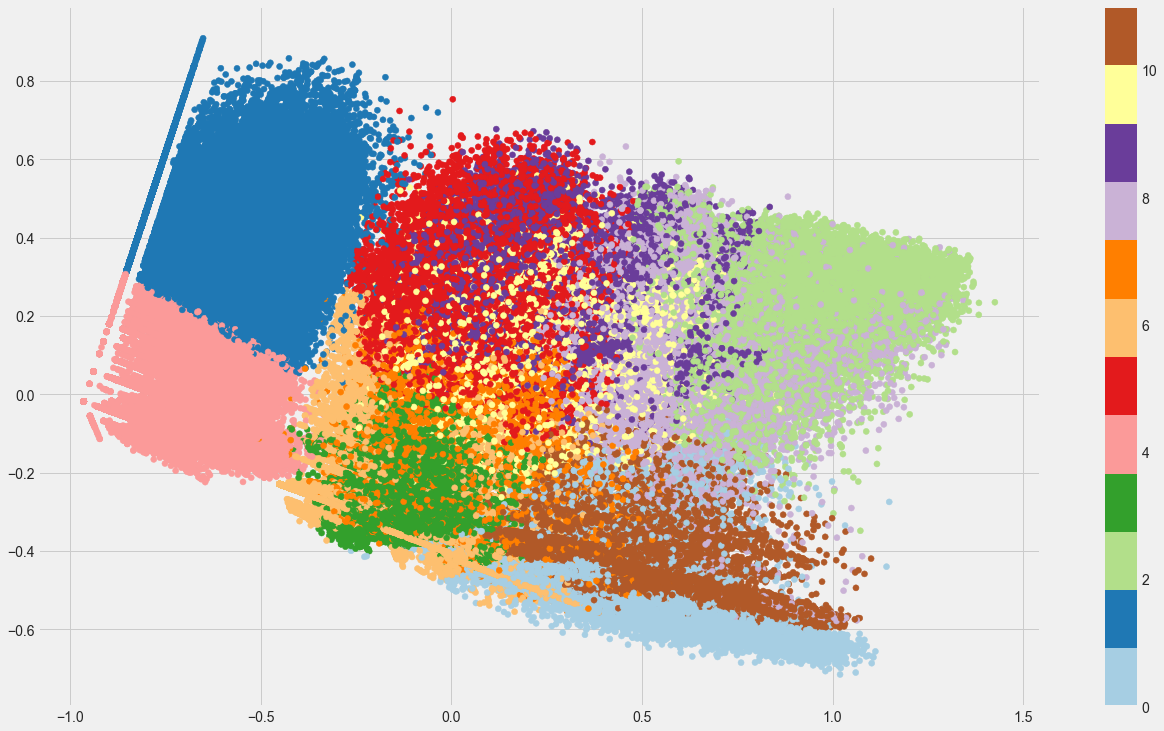

In [198]:
plt.figure(figsize = (20, 12))
plt.scatter(data_2D[:, 0], data_2D[:, 1], c = kmeans_12.labels_, cmap = 'Paired')
plt.colorbar();

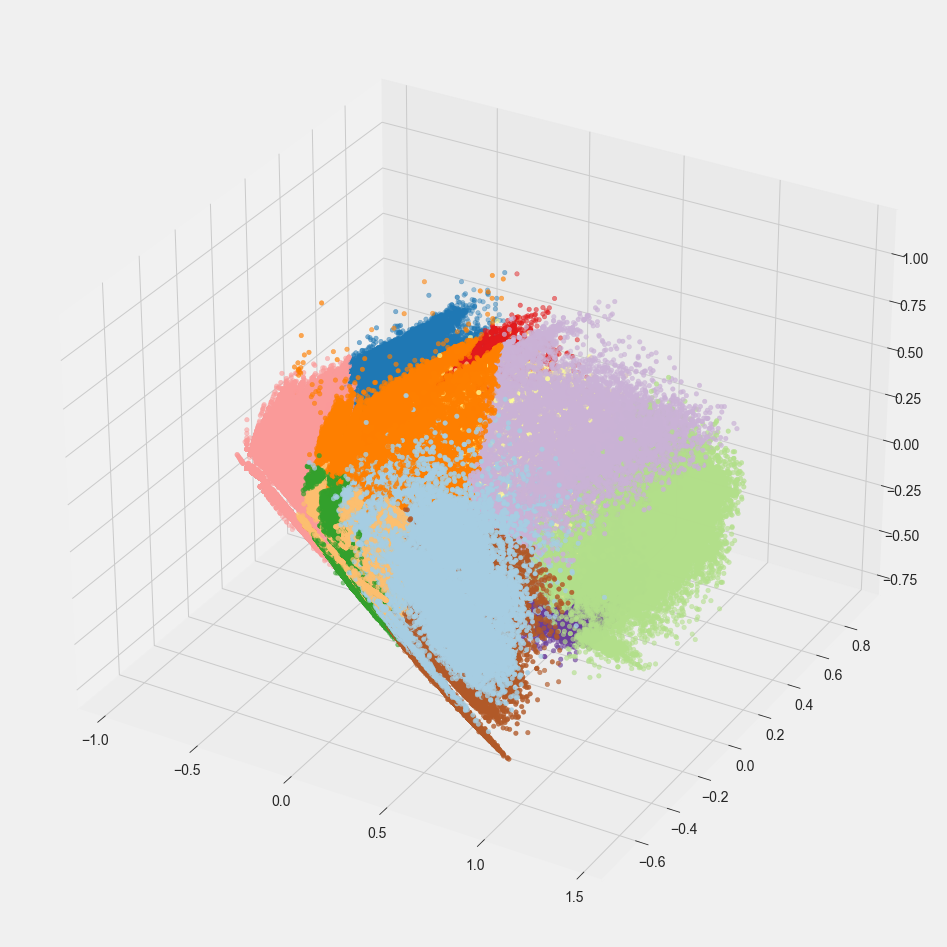

In [199]:
fig = plt.figure(figsize = (20, 16))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(data_3D[:, 0], data_3D[:, 1], data_3D[:, 2], c = kmeans_12.labels_, cmap = 'Paired')
plt.show()

<h2>Cluster Analysis</h2>

First of all, let's look at how many elements are in each cluster and their percentage distribution.

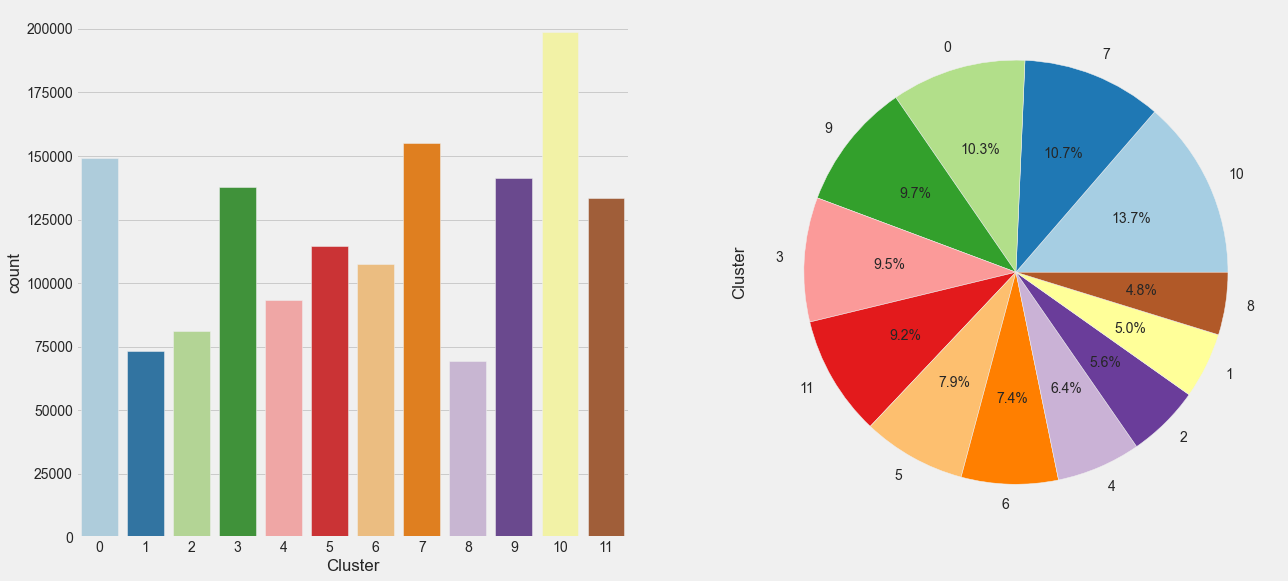

In [200]:
plt.figure(figsize = (30, 20))
plt.subplot(234)
sb.countplot(clustered_food_df['Cluster'], palette = 'Paired')
plt.subplot(235)
clustered_food_df['Cluster'].value_counts().plot.pie(cmap = 'Paired', autopct = '%1.1f%%');

From this plot can be seen that count of elements in each cluster varies from 70000 to 200000, which is quite good.

<h3>Feature distributions in clusters:</h3>

<h3>Calcium:</h3>

In [201]:
column_name = 'Calcium'

In [202]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        8         6         9         7         2         10        0   \
mean     0.081304  0.099496  0.148942  0.164485  0.172524  0.194092  0.201662   

Cluster        5         1         3         4         11  
mean     0.234888  0.381379  0.395323  0.436357  0.605941

<h3>Ply Fat:</h3>

In [203]:
column_name = 'Ply Fat'

In [204]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        2         6         0         9         7         10        1   \
mean     0.000025  0.000116  0.000134  0.000156  0.000206  0.000272  0.000478   

Cluster        3         5         8         11        4   
mean     0.000722  0.000758  0.001016  0.001842  0.004435

<h3>Carbs:</h3>

In [205]:
column_name = 'Carbs'

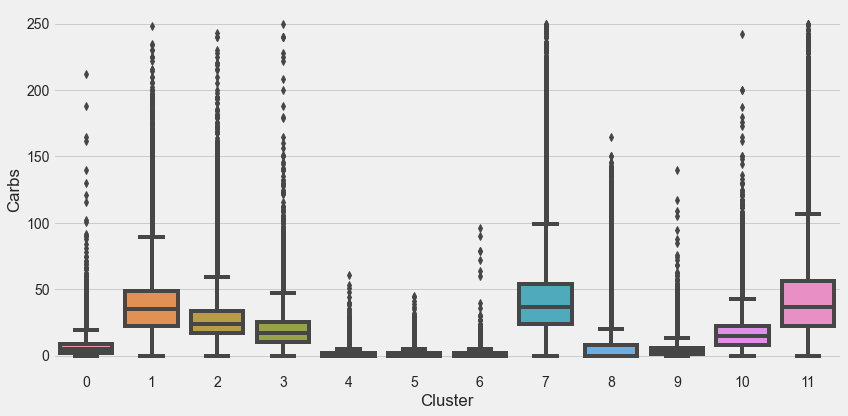

In [206]:
plt.figure(figsize = (12, 6))
ax = sb.boxplot(x = 'Cluster', y = column_name, data = clustered_food_df);
fig = plt.gcf()
plt.tight_layout()

In [207]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        6         5         4         9         0         8   \
mean     1.330256  1.347696  1.867299  3.829497  5.858071  7.223649   

Cluster         10         3          2          1          7          11  
mean     15.781141  18.430581  27.967999  37.890725  42.054391  42.407871

<h3>Chol:</h3>

In [208]:
column_name = 'Chol'

In [209]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        6         0         2         9         3         10        8   \
mean     0.032379  0.072851  0.101245  0.133129  0.163501  0.298641  0.498751   

Cluster        7         1         11        4         5   
mean     1.222797  1.387591  1.452899  1.746293  2.390589

<h3>Fiber:</h3>

In [210]:
column_name = 'Fiber'

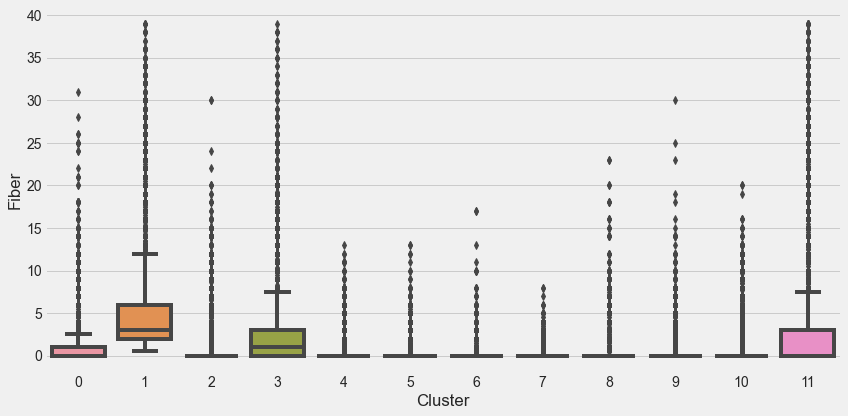

In [211]:
plt.figure(figsize = (12, 6))
ax = sb.boxplot(x = 'Cluster', y = column_name, data = clustered_food_df);
fig = plt.gcf()
plt.tight_layout()

In [212]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        7         6         4         8         5        9         2   \
mean     0.031528  0.039885  0.049342  0.050573  0.051002  0.28463  0.493638   

Cluster        10        0         3         11        1   
mean     0.565519  0.750132  1.791617  2.343404  4.487828

<h3>Protein:</h3>

In [213]:
column_name = 'Protein'

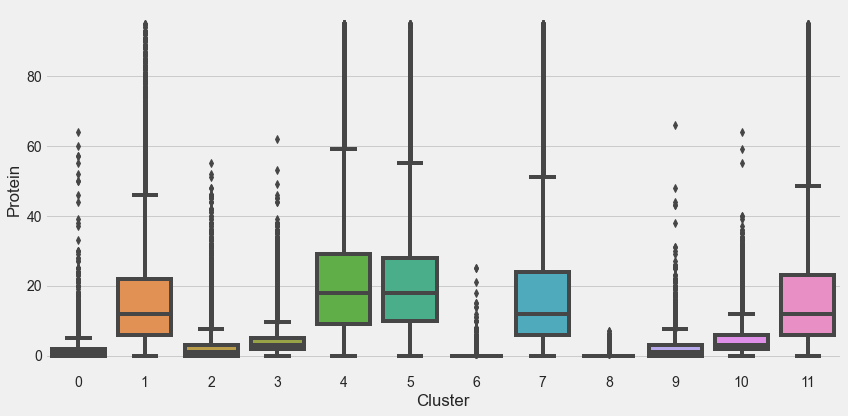

In [214]:
plt.figure(figsize = (12, 6))
ax = sb.boxplot(x = 'Cluster', y = column_name, data = clustered_food_df);
fig = plt.gcf()
plt.tight_layout()

In [215]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        8         6         0         9         2         3         10  \
mean     0.091073  0.139475  1.771491  2.217107  2.300138  4.240484  4.488521   

Cluster         1          11         7          4          5   
mean     15.723908  16.787704  17.018848  21.195836  21.280629

<h3>Calories:</h3>

In [216]:
column_name = 'Calories'

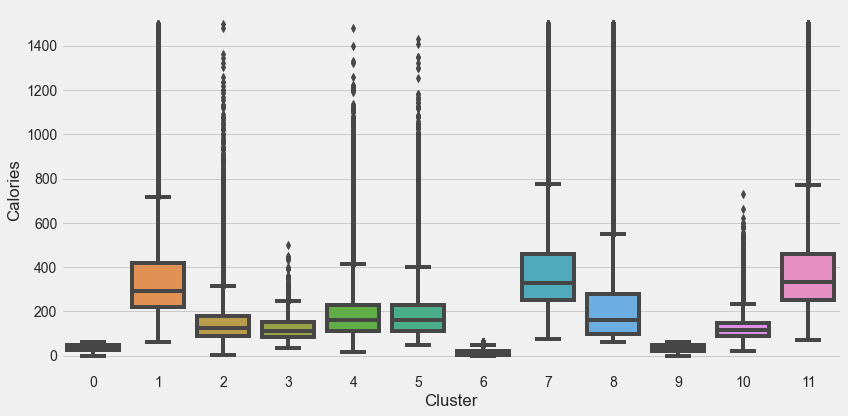

In [217]:
plt.figure(figsize = (12, 6))
ax = sb.boxplot(x = 'Cluster', y = column_name, data = clustered_food_df);
fig = plt.gcf()
plt.tight_layout()

In [218]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster         6         9         0           3           10          2   \
mean     13.781178  34.76782  36.66509  120.047138  120.501726  149.087062   

Cluster          5           4           8           1           7   \
mean     185.394411  188.746069  223.830465  347.693014  386.555363   

Cluster          11  
mean     386.760642

<h3>Trn Fat:</h3>

In [219]:
column_name = 'Trn Fat'

In [220]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster   0    9         5         6         10        3         8         2   \
mean     0.0  0.0  0.000035  0.000037  0.000091  0.000109  0.000231  0.000241   

Cluster        7         4        1         11  
mean     0.000312  0.000386  0.00054  0.000554

<h3>Fat:</h3>

In [221]:
column_name = 'Fat'

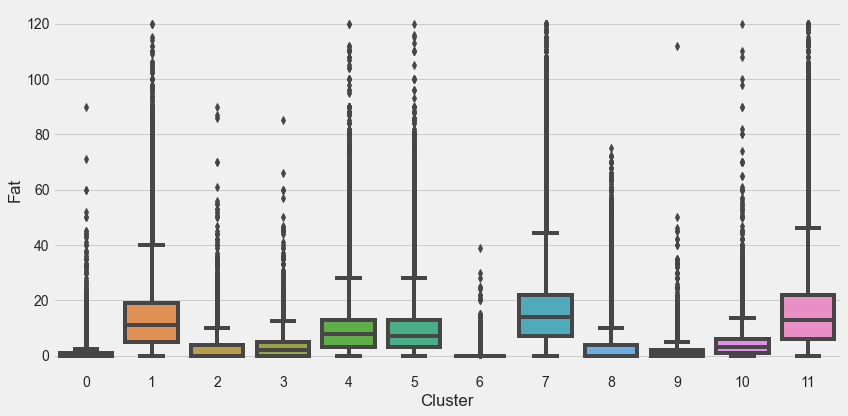

In [222]:
plt.figure(figsize = (12, 6))
ax = sb.boxplot(x = 'Cluster', y = column_name, data = clustered_food_df);
fig = plt.gcf()
plt.tight_layout()

In [223]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        6        0         9         2      3         8         10  \
mean     0.472865  0.88043  1.288858  2.428749  3.205  3.536629  4.230245   

Cluster        5         4          1          11         7   
mean     9.362557  9.624426  13.833622  16.175078  16.434164

<h3>Potass.:</h3>

In [224]:
column_name = 'Potass.'

In [225]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        6         8         9         10        7        0        2   \
mean     1.495018  2.577327  2.697832  3.143396  3.404427  3.78084  4.79601   

Cluster        4         11        1         5         3   
mean     5.374921  5.583316  6.019765  6.098277  6.788398

<h3>Iron:</h3>

In [226]:
column_name = 'Iron'

In [227]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        8         9         6        0         2         10        5   \
mean     0.053714  0.080239  0.088496  0.16895  0.171281  0.216221  0.251626   

Cluster        7         4         3         1         11  
mean     0.290039  0.414348  0.500246  0.571634  0.906436

<h3>Sat Fat:</h3>

In [228]:
column_name = 'Sat Fat'

In [229]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        6         9        0        10        3         8         5   \
mean     0.007934  0.011385  0.01193  0.04133  0.054598  0.060112  0.077603   

Cluster        2         7        1         4         11  
mean     0.077872  0.083567  0.13342  0.164699  0.260595

<h3>Vit A:</h3>

In [230]:
column_name = 'Vit A'

In [231]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        5         7         2         8         1         6         10  \
mean     0.002453  0.004276  0.006706  0.009178  0.010957  0.013919  0.015146   

Cluster        9         4         11        0         3   
mean     0.024449  0.028197  0.031728  0.037167  0.051243

<h3>Sodium:</h3>

In [232]:
column_name = 'Sodium'

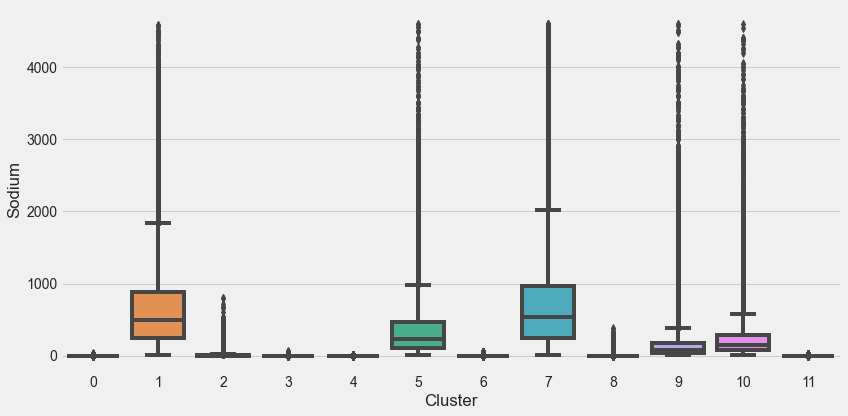

In [233]:
plt.figure(figsize = (12, 6))
ax = sb.boxplot(x = 'Cluster', y = column_name, data = clustered_food_df);
fig = plt.gcf()
plt.tight_layout()

In [234]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        4         11        3         0         6         8        2   \
mean     0.117099  0.250496  0.784348  1.006514  1.316193  1.337764  9.98857   

Cluster          9           10          5           1           7   
mean     147.370213  222.818514  346.051675  650.508396  703.183544

<h3>Vit C:</h3>

In [235]:
column_name = 'Vit C'

In [236]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        7         4         5         10        9         6         8   \
mean     0.018599  0.022326  0.022653  0.023594  0.029744  0.035613  0.040776   

Cluster       2         11        0         1         3   
mean     0.04597  0.053256  0.057026  0.073861  0.083676

<h3>Sugar:</h3>

In [237]:
column_name = 'Sugar'

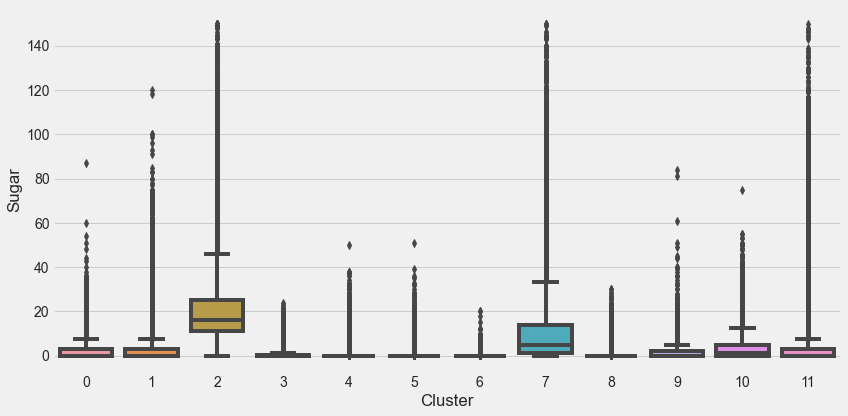

In [238]:
plt.figure(figsize = (12, 6))
ax = sb.boxplot(x = 'Cluster', y = column_name, data = clustered_food_df);
fig = plt.gcf()
plt.tight_layout()

In [239]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        6         5        8         4         3         9         0   \
mean     0.170442  0.181593  0.19765  0.306775  0.760533  1.222358  2.229235   

Cluster        1         10        11         7          2   
mean     2.766029  3.491159  4.205525  10.339923  20.781009

<h3>Mon Fat:</h3>

In [240]:
column_name = 'Mon Fat'

In [241]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster   2        6         9         0         10        1         7   \
mean     0.0  0.00007  0.000071  0.000094  0.000186  0.000191  0.000348   

Cluster        5         8         3         4      11  
mean     0.000401  0.000403  0.001193  0.001628  0.002

<h3>Food Heaviness:</h3>

In [242]:
column_name = 'Food Heaviness'

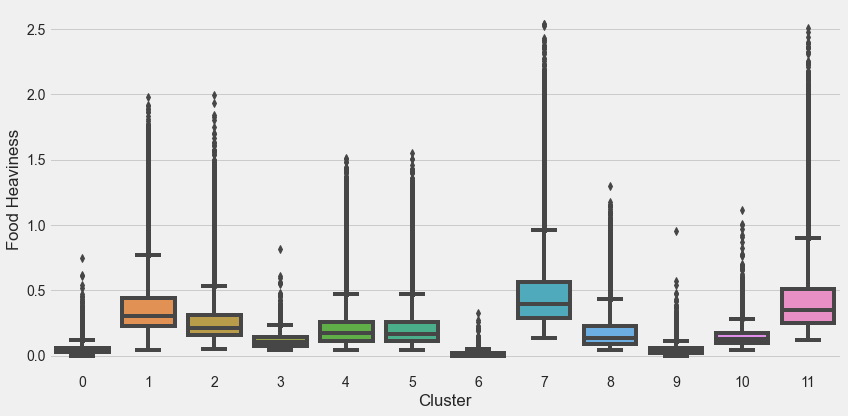

In [243]:
plt.figure(figsize = (12, 6))
ax = sb.boxplot(x = 'Cluster', y = column_name, data = clustered_food_df);
fig = plt.gcf()
plt.tight_layout()

In [244]:
clustered_food_df.groupby(['Cluster'])[column_name].agg([np.mean]).sort_values(by = 'mean', ascending = True).T

Cluster        6         9         0        3         10       8         5   \
mean     0.014264  0.042068  0.046642  0.11181  0.138861  0.18001  0.202828   

Cluster        4         2         1        11        7   
mean     0.208079  0.258171  0.365516  0.42067  0.463588

<h3>Calorie Category:</h3>

In [245]:
column_name = 'Calorie Category'

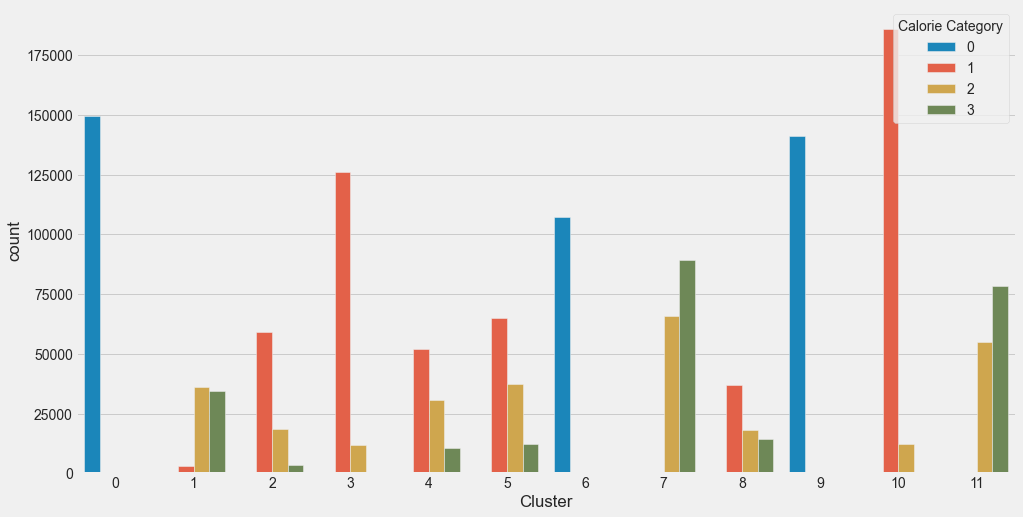

In [246]:
plt.figure(figsize = (15, 8))
sb.countplot(x = 'Cluster', hue = 'Calorie Category', data = clustered_food_df);

|                	|          Carbs          	|          Fiber          	|         Protein         	|        Calories        	|           Fat           	|         Sodium         	|          Sugar          	|      Food Heaviness     	| Calorie Category 	|
|:--------------:	|:-----------------------:	|:-----------------------:	|:-----------------------:	|:----------------------:	|:-----------------------:	|:----------------------:	|:-----------------------:	|:-----------------------:	|:----------------:	|
| **Cluster 0**  	|    Low; Mean: 5.8; N8   	| Average; Mean: 0.75; N4 	|   Low; Mean: 1.77; N10  	|   Low; Mean: 36; N10   	|   Low; Mean: 0.88; N11  	|    Low; Mean: 1; N9    	| Average; Mean: 2.22; N6 	|   Low; Mean: 0.04; N10  	|        Low       	|
| **Cluster 1**  	|   High; Mean: 37.8; N3  	|   High; Mean: 4.48; N1  	| Average; Mean: 15.7; N5 	|   High; Mean: 347; N3  	|   High; Mean: 13.8; N3  	|   High; Mean: 650; N2  	| Average; Mean: 2.76; N5 	|   High; Mean: 0.36; N3  	|       High       	|
| **Cluster 2**  	|  Average; Mean: 28; N4  	| Average; Mean: 0.49; N6 	|    Low; Mean: 2.3; N8   	| Average; Mean: 149; N7 	|   Low; Mean: 2.42; N9   	|   Low; Mean: 9.98; N6  	|   High; Mean: 20.7; N1  	| Average; Mean: 0.25; N4 	|      Average     	|
| **Cluster 3**  	| Average; Mean: 18.4; N5 	|   High; Mean: 1.79; N3  	|   Low; Mean: 4.24; N7   	| Average; Mean: 120; N9 	|    Low; Mean: 3.2; N8   	|  Low; Mean: 0.78; N10  	|   Low; Mean: 0.76; N8   	| Average; Mean: 0.11; N9 	|      Average     	|
| **Cluster 4**  	|   Low; Mean: 1.8; N10   	|   Low; Mean: 0.04; N10  	|   High; Mean: 21.2; N2  	| Average; Mean: 188; N5 	| Average; Mean: 9.62; N4 	|  Low; Mean: 0.11; N12  	|    Low; Mean: 0.3; N9   	|  Average; Mean: 0.2; N5 	|      Average     	|
| **Cluster 5**  	|   Low; Mean: 1.3; N11   	|   Low; Mean: 0.05; N8   	|   High; Mean: 21.3; N1  	| Average; Mean: 185; N6 	| Average; Mean: 9.36; N5 	| Average; Mean: 346; N3 	|   Low; Mean: 0.18; N11  	|  Average; Mean: 0.2; N6 	|      Average     	|
| **Cluster 6**  	|   Low; Mean: 1.3; N12   	|   Low; Mean: 0.03; N11  	|   Low; Mean: 0.14; N11  	|   Low; Mean: 13; N12   	|   Low; Mean: 0.47; N12  	|   Low; Mean: 1.31; N8  	|   Low; Mean: 0.17; N12  	|   Low; Mean: 0.01; N12  	|        Low       	|
| **Cluster 7**  	|    High; Mean: 42; N2   	|   Low; Mean: 0.03; N12  	|  Average; Mean: 17; N3  	|   High; Mean: 386; N2  	|   High; Mean: 16.4; N1  	|   High; Mean: 703; N1  	|   High; Mean: 10.3; N2  	|   High; Mean: 0.46; N1  	|       High       	|
| **Cluster 8**  	|    Low; Mean: 7.2; N7   	|   Low; Mean: 0.05; N9   	|   Low; Mean: 0.09; N12  	| Average; Mean: 223; N4 	|   Low; Mean: 3.53; N7   	|   Low; Mean: 1.33; N7  	|   Low; Mean: 0.19; N10  	| Average; Mean: 0.18; N7 	|      Average     	|
| **Cluster 9**  	|    Low; Mean: 3.8; N9   	| Average; Mean: 0.28; N7 	|   Low; Mean: 2.21; N9   	|   Low; Mean: 34; N11   	|   Low; Mean: 1.28; N10  	| Average; Mean: 147; N5 	| Average; Mean: 1.22; N7 	|   Low; Mean: 0.04; N11  	|        Low       	|
| **Cluster 10** 	| Average; Mean: 15.7; N6 	| Average; Mean: 0.55; N5 	|   Low; Mean: 4.48; N6   	| Average; Mean: 120; N8 	|   Low; Mean: 4.23; N6   	| Average; Mean: 222; N4 	| Average; Mean: 3.49; N4 	| Average; Mean: 0.13; N8 	|      Average     	|
| **Cluster 11** 	|    High; Mean: 42; N1   	|   High; Mean: 2.34; N2  	| Average; Mean: 16.8; N4 	|   High; Mean: 386; N1  	|   High; Mean: 16.1; N2  	|  Low; Mean: 0.25; N11  	|  Average; Mean: 4.2; N3 	|   High; Mean: 0.42; N2  	|       High       	|

Let's start with most notable clusters.

Most notable one is probably `Cluster 7`, It has low fiber, average protein and everythin other high. This cluster probably would be for unhealthy and heavy food. First example that comes to minds is Snickers, after checking its consistency it is clear that Snickers is the average representative of this cluster. Also pizzas and shawarmas would belong here too.

Next cluster is `Cluster 11`, it is also pretty heavy but it has low sodium and not high sugar while having high fiber and carbs. Low sodium means that there is not much Smoked, cured, salted or canned meat, also no pizzas, buritos and shawarmas, this in combination with high fiber and carbs means that it has more food made of dough like Khachapuri and so on.

`Cluster 1` is only notably different from `Cluster 11` with having high sodium average, while having little bit less of heaviness. This would be ideal cluster for sandwiches and stuff like that.

Now that we are out of high calories clusters first thing that strikes the eye is `Cluster 2`, by having abnormally high sugar average, this cluster would definitely be for sugar sweets, other stats further encourage this statement too. But heavy sweets like snickers would still go in `Cluster 7` though.

If we look at `Cluster 5` it would be ideal cluster for Mtsvadi or eggs with low carbs, fiber, high protein and higher average of sodium and calories. Also average heaviness.

`Cluster 3` would be ideal cluster for pastas/rice and stuff like that, because of high fiber, high end of cabrs. and average calories as well as heaviness.

`Cluster 6` is definitely for some drinks and lightest of foods, like water, cofee or strict diet foods/vegetables.

`Cluster 10` is more like for fruits, banana would be ideal representative of this cluster.

`Cluster 0` is definitely for porridges, cereals, berries and such light diet food.

`Cluster 4` would be for chicken breast, cheese, yogurt and other healthy foods with high protein and average calorie values.

As for `Clusters 8` and `Cluster 9` they would still be for different kinds of fruits and diet foods.

<h1><span style="color:blue">Clustering With SOMPY</span></h1>

To reinforce our problem, we can use another clustering method - SOMPY (Self-organizing map), which is a type of artificial neural network that is trained using unsupervised learning to produce two-dimensional, discretized representation of the input space of the training samples, called a map.

<h3>Import libraries:</h3>

In [247]:
import glob
import random
import joblib

from sompy.sompy import SOMFactory
from sompy.visualization.mapview import View2D
from sompy.visualization.hitmap import HitMapView
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.plot_tools import plot_hex_map

<h3>Creating models:</h3>

At first, let's define some useful variables:

In [248]:
data = clustering_df.values
names = clustering_variables

And now let's train the model with different parameters. The more, the better. Each iteration is stored in disk for further study. For demonstration purposes we created only 20 models, since it takes too much time for building each of them. So, this code will be commented.

In [249]:
# for i in range(20): 
#     sm = SOMFactory().build(data,
#                             mapsize = [random.choice(list(range(15, 25))), random.choice(list(range(10, 15)))],
#                             initialization = 'random',
#                             component_names = names,
#                             lattice = 'hexa') 
#     sm.train(n_job = 4, verbose = False, train_rough_len = 30, train_finetune_len = 100) 
#     joblib.dump(sm, 'model_{}.joblib'.format(i))

Study the models trained and plot the errors obtained in order to select the best one.

In [250]:
models_pool = glob.glob('./models/model*')
errors = []

for model_filepath in models_pool:
    sm = joblib.load(model_filepath)
    topographic_error = sm.calculate_topographic_error()
    quantization_error = sm.calculate_quantization_error()
    errors.append((topographic_error, quantization_error))

e_top, e_q = zip(*errors)

 find_bmu took: 5.985000 seconds
 find_bmu took: 7.082000 seconds
 find_bmu took: 7.266000 seconds
 find_bmu took: 4.922000 seconds
 find_bmu took: 6.204000 seconds
 find_bmu took: 5.073000 seconds
 find_bmu took: 8.297000 seconds
 find_bmu took: 8.253000 seconds
 find_bmu took: 7.473000 seconds
 find_bmu took: 5.863000 seconds
 find_bmu took: 6.862000 seconds
 find_bmu took: 5.826000 seconds
 find_bmu took: 6.205000 seconds
 find_bmu took: 7.111000 seconds
 find_bmu took: 6.224000 seconds
 find_bmu took: 6.845000 seconds
 find_bmu took: 8.930000 seconds
 find_bmu took: 8.121000 seconds
 find_bmu took: 6.701000 seconds
 find_bmu took: 8.621000 seconds
 find_bmu took: 7.529000 seconds
 find_bmu took: 5.622000 seconds
 find_bmu took: 6.220000 seconds
 find_bmu took: 5.710000 seconds
 find_bmu took: 11.520000 seconds
 find_bmu took: 17.442000 seconds
 find_bmu took: 15.645000 seconds
 find_bmu took: 17.453000 seconds
 find_bmu took: 20.902000 seconds
 find_bmu took: 20.483000 seconds
 fin

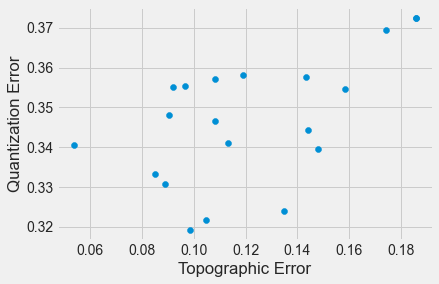

In [251]:
plt.scatter(e_top, e_q)
plt.xlabel('Topographic Error')
plt.ylabel('Quantization Error')
plt.show()

We need to minimize topographic error, so we will manually choose model with the lowest topographic error.

In [252]:
selected_model = 0
sm = joblib.load(models_pool[selected_model])

topographic_error = sm.calculate_topographic_error()
quantization_error = sm.calculate_quantization_error()
print ('Topographic error = %s\nQuantization error = %s' % (topographic_error, quantization_error))

 find_bmu took: 10.252000 seconds
 find_bmu took: 11.523000 seconds
 find_bmu took: 12.095000 seconds


Topographic error = 0.05377802793051527
Quantization error = 0.34064460338018965


<h3>Results:</h3>

The components map shows the values of the variables for each prototype and allows us to extract conclusions consisting of non-linear patterns between variables. It shows the patterns learned by the neural network which are used to determine de winning neuron of each training instance.

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A6A6B3D4A8>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A6A6B3D4A8> on colorbar
Setting pcolormesh
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A6A4E19EF0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A6A4E19EF0> on colorbar
Setting pcolormesh
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A6AFF48630>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A6AFF48630> on colorbar
Setting pcolormesh
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A6B79B99E8>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A6B79B99E8> on colorbar
Setting pcolormesh
locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A6A4E35080>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator o

findfont: score(<Font 'MS Reference Sans Serif' (REFSAN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Papyrus' (PAPYRUS.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Bright' (LBRITEDI.TTF) italic normal 600 normal>) = 11.24
findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (seguisbi.ttf) italic normal 600 normal>) = 11.24
findfont: score(<Font 'Calisto MT' (CALISTBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Constantia' (constani.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Candara' (Candarali.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Perpetua Titling MT' (PERTILI.TTF) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Microsoft New Tai Lue' (ntailub.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Malgun Gothic' (malgunsl.ttf) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Fr

findfont: score(<Font 'Book Antiqua' (ANTQUAI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Palace Script MT' (PALSCRI.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Consolas' (consolab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Ebrima' (ebrima.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Maiandra GD' (MAIAN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Comic Sans MS' (comicz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Segoe UI' (segoeuib.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Copperplate Gothic Bold' (COPRGTB.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Leelawadee UI' (LeelaUIb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Centaur' (CENTAUR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Informal Roman' (INFROMAN.TT

findfont: score(<Font 'Cambria' (cambriaz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Californian FB' (CALIFR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Fax' (LFAXDI.TTF) italic normal 600 normal>) = 11.24
findfont: score(<Font 'Georgia' (georgiai.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Malgun Gothic' (malgunbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Century Gothic' (GOTHIC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Eras Demi ITC' (ERASDEMI.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT Condensed' (TCCB____.TTF) normal normal 700 condensed>) = 10.535
findfont: score(<Font 'Times New Roman' (timesbi.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'High Tower Te

findfont: score(<Font 'Yu Gothic' (YuGothB.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lucida Sans' (LSANSDI.TTF) italic normal 600 normal>) = 11.24
findfont: score(<Font 'Niagara Engraved' (NIAGENG.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (segoeuiz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Arial Rounded MT Bold' (ARLRDBD.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'MS Outlook' (OUTLOOK.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Consolas' (consolaz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Arial' (arialbi.ttf) italic normal 700 normal>) = 1.335
findfont: score(<Font 'Wingdings 3' (WINGDNG3.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Sitka Small' (Sitka.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Blackadder ITC' (ITCBLKAD.TTF) no

findfont: score(<Font 'Malgun Gothic' (malgunsl.ttf) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Perpetua Titling MT' (PERTIBD.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Arial' (arial.ttf) normal normal 400 normal>) = 0.05
findfont: score(<Font 'Century Gothic' (GOTHICI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Consolas' (consola.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Rockwell Extra Bold' (ROCKEB.TTF) normal normal 800 normal>) = 10.43
findfont: score(<Font 'Lucida Fax' (LFAXI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Papyrus' (PAPYRUS.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Leelawadee UI' (LeelawUI.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Candara' (Candarab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Bodoni MT' (BOD_CB.TTF) normal normal 700 condensed>) = 10.535
findfont: score(<Font 'Arial' (arialbd.ttf) normal normal 7

findfont: score(<Font 'Bodoni MT' (BOD_BLAI.TTF) italic normal 900 normal>) = 11.525
findfont: score(<Font 'Gloucester MT Extra Condensed' (GLECB.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Tw Cen MT' (TCBI____.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'OCR A Extended' (OCRAEXT.TTF) normal normal 400 expanded>) = 10.25
findfont: score(<Font 'Century Schoolbook' (SCHLBKI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Trebuchet MS' (trebuc.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Candara' (Candara.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Wide Latin' (LATINWD.TTF) normal normal 400 expanded>) = 10.25
findfont: score(<Font 'Tw Cen MT Condensed' (TCCB____.TTF) normal normal 700 condensed>) = 10.535
findfont: score(<Font 'HP Simplified' (HPSimplified_Rg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bookman Old Style' (BOOKOSBI.TTF) italic normal 600 normal>) = 11.24
findfon

findfont: score(<Font 'Informal Roman' (INFROMAN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe UI' (seguibl.ttf) normal normal 900 normal>) = 10.525
findfont: score(<Font 'Consolas' (consolai.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Lucida Bright' (LBRITED.TTF) normal normal 600 normal>) = 10.24
findfont: score(<Font 'Microsoft Tai Le' (taileb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'HP Simplified' (HPSimplified_Lt.ttf) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Arial' (ariali.ttf) italic normal 400 normal>) = 1.05
findfont: score(<Font 'Book Antiqua' (ANTQUAI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'HoloLens MDL2 Assets' (holomdl2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Monotype Corsiva' (MTCORSVA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bookman Old 

findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeTwoSym' (STIXSizTwoSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmsy10' (cmsy10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 norm

findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEO.TTF) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'Myanmar Text' (mmrtextb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Vivaldi' (VIVALDII.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Nirmala UI' (Nirmala.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Verdana' (verdanai.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Lucida Fax' (LFAX.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_CR.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Kristen ITC' (ITCKRIST.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe MDL2 Assets' (segmdl2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bodoni MT' (BOD_BI.TTF) italic normal 70

findfont: score(<Font 'Mistral' (MISTRAL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Garamond' (GARAIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Agency FB' (AGENCYR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bell MT' (BELL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Broadway' (BROADW.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Viner Hand ITC' (VINERITC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Freestyle Script' (FREESCPT.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT' (TCMI____.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Gigi' (GIGI.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Footlight MT Light' (FTLTLT.TTF) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Microsoft New Tai Lue' (ntailub.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'HP Simplified' (HPSimplified_BdIt.ttf) italic 

findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Bell MT' (BELLI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Nirmala UI' (NirmalaB.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Century Gothic' (GOTHICBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Bookman Old Style' (BOOKOS.TTF) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Matura MT Script Capitals' (MATURASC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trebuchet MS' (trebucbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Corbel' (corbeli.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Segoe UI' (segoeuii.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Snap ITC' (SNAP____.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT Condensed Ex

findfont: score(<Font 'Javanese Text' (javatext.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Microsoft Yi Baiti' (msyi.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'MingLiU-ExtB' (mingliub.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Microsoft Himalaya' (himalaya.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Century Schoolbook' (CENSCBK.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT Condensed' (TCCM____.TTF) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Haettenschweiler' (HATTEN.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Monotype Corsiva' (MTCORSVA.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Calligraphy' (LCALLIG.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Segoe UI' (segoeuil.ttf) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Segoe UI' (seguili.ttf) italic normal 300 normal>) = 11.145
findfont: score

findfont: score(<Font 'Poor Richard' (POORICH.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Franklin Gothic Heavy' (FRAHV.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Stencil' (STENCIL.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'MS Gothic' (msgothic.ttc) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Georgia' (georgiaz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Lucida Calligraphy' (LCALLIG.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Franklin Gothic Demi' (FRADMIT.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Constantia' (constanz.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Bookman Old Style' (BOOKOSB.TTF) normal normal 600 normal>) = 10.24
findfont: score(<Font 'Century Schoolbook' (SCHLBKBI.TTF) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Parchment' (PARCHM.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Wingdings 3

findfont: score(<Font 'Arial' (arial.ttf) normal normal 400 normal>) = 0.05
findfont: score(<Font 'Eras Demi ITC' (ERASDEMI.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Segoe Script' (segoescb.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Microsoft New Tai Lue' (ntailu.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Sans Typewriter' (LTYPEB.TTF) normal normal 600 normal>) = 10.24
findfont: score(<Font 'Bell MT' (BELLB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Palatino Linotype' (palai.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Sitka Small' (SitkaZ.ttc) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Trebuchet MS' (trebucit.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Corbel' (corbel.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Gill Sans MT' (GILB____.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Bahnschrift' (bahnschrift.tt

findfont: score(<Font 'Matura MT Script Capitals' (MATURASC.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Eras Bold ITC' (ERASBD.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lucida Bright' (LBRITEI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Berlin Sans FB Demi' (BRLNSDB.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Castellar' (CASTELAR.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Wingdings' (wingding.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Elephant' (ELEPHNTI.TTF) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Lucida Bright' (LBRITE.TTF) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Tw Cen MT' (TCB_____.TTF) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Book Antiqua' (BKANT.T

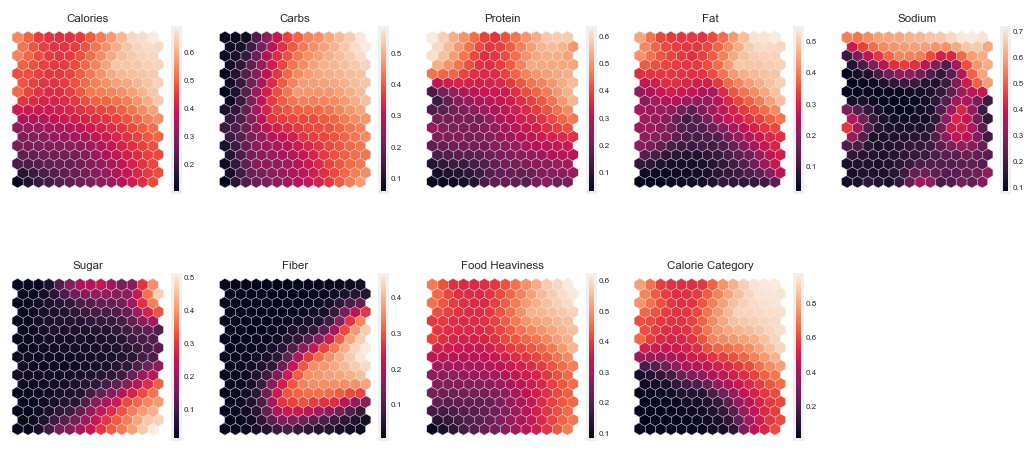

In [253]:
view2D = View2D(20, 20, '', text_size = 8)
view2D.show(sm, col_sz = 5, which_dim = 'all', denormalize = True)
plt.show()

<h4>Hits-map:</h4>

This visualization is very important because it shows how the instances are spreaded across the hexagonal lattice. The more instances lay into a cell, the more instances it is representing and hence the more we have to take it into acount.

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A580F76C88>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A580F76C88> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


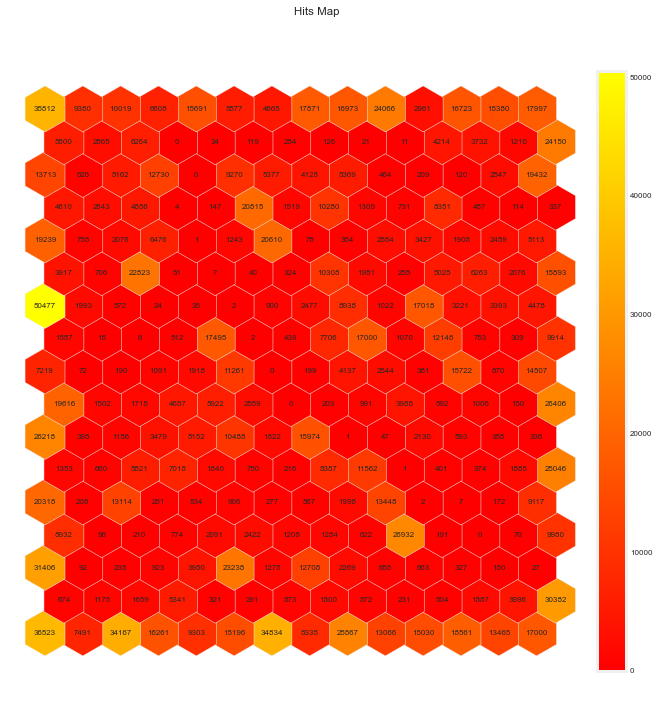

In [254]:
vhts = BmuHitsView(12, 12, 'Hits Map', text_size = 8)
vhts.show(sm, anotate = True, onlyzeros = False, labelsize = 8, cmap = 'autumn', logaritmic = False)
plt.show()

<h3>Clustering:</h3>

Now, let's try to divide our data into 12 clusters. This visualization helps us to focus on the groups which share similar characteristics.

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A6BFB517F0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001A6BFB517F0> on colorbar
Setting pcolormesh


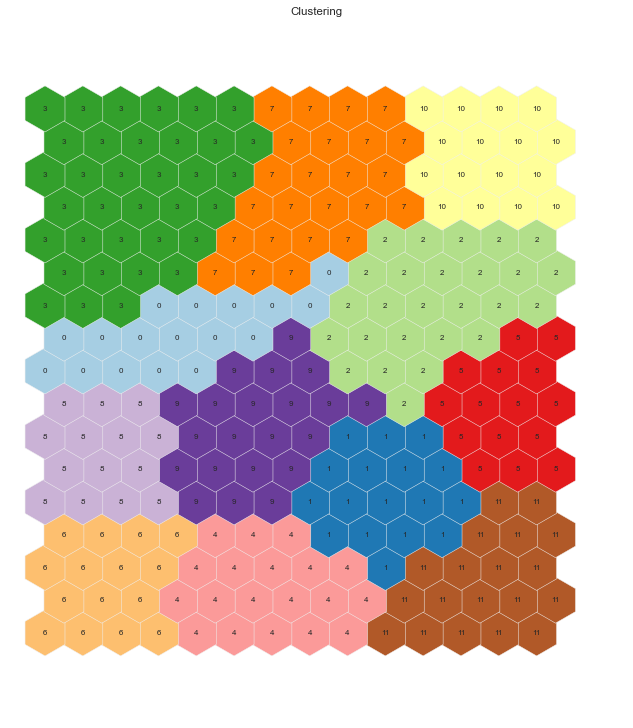

In [255]:
sm.cluster(12)

hits = HitMapView(12, 12, 'Clustering', text_size = 10, cmap = plt.cm.jet)
a = hits.show(sm, anotate = True, onlyzeros = False, labelsize = 8, cmap = 'Paired')
plt.show()

<h2>Cluster Analysis</h2>

We can make use of K-Means' clusters to simplify process of explaining SOMPY's clusters. For example, looking at the above described components map, we can notice that `Calories` are gathered mostly in the upper right corner. Using similar logic for every nutrition, we can conclude that, for example, SOMPY's 10th, 7th and 2nd clusters are similar to K_means' 11th, 7th and 1st clusters respectively. In addition, 6th clusters are same in both cluster sets, since they have lowest values for each nutrition. Observing mainly `Protein` and also other components we can infer that 3rd cluster in SOMPY is similar with 5th cluster in K-Means. 4th (SOMPY) and 9th (K-Means) clusters are also similar. Same goes for 11th (SOMPY) and 2nd (K-Means), 5th (SOMPY) and 3rd K-means and so on.

<h1><span style="color:blue">Usage</span></h1>

After clustering food we can start talking about usage of these clusters. As we mentioned in the start of this project there are many ways of using food clusters. These clusters can be useful both for app development and marketing reasons. We can briefly overview several of our usage ideas:

First usage of our clusters could be for improving service with personalized suggestions. For example, if someone is taking more `Calories` than their goal, we could suggest food from the category that is closest to his intake, but has lower `Calories` consistency.

As we know in the modern society a lot of peopel have trouble starting diet from a scratch. So, to address that issue, we can build a diet plan that starts from the current `Food Heaviness` level of user and reduces it gradually, suggesting food from different categories.

Other usage could be for personalized advertisements. For example, if we know that user has tendency of eating food from 11th category (K-Means), we can show them McDonald's ad (probably we aren't supposed to that, since it is a healthy lifestyle app, but it's ok just for an example). Also, if user takes food daily from any category we can advertise other food from that category.

# ------------------------------------------------ THE END ------------------------------------------------